In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

### Constants and global parameters

In [2]:
c= 299792458.
G=6.67408e-11 
pc_to_light_year = 3.26156  
pc_to_m = pc_to_light_year*c*86400*365.25
H0 = 67.9*1000/(1000000*pc_to_m)
print(pc_to_m, H0)

3.085674008015063e+16 2.2004916858886974e-18


### Usual plotting style

In [3]:
# Parameters for matplotlib (these should be the same as the ones used for SHD)
fontsize = 20
matplotlib.rcParams.update({
    "font.size": fontsize,
    "axes.titlesize": fontsize,
    "axes.labelsize": fontsize, #* 2,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "xtick.major.size": fontsize * .8,
    "ytick.major.size": fontsize * .8,
    "legend.fontsize": fontsize/2-1,
    #"font.family": "Times new Roman",
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "text.usetex": True,
    "path.simplify": True,
    "figure.figsize": (8, 6)
})

plt.rcParams["figure.facecolor"] = "w"


# Class to deal in an easy way with number of digits in colorbars (used for ULs and sigma maps)
class FormatScalarFormatter(matplotlib.ticker.ScalarFormatter):
            def __init__(self, fformat="%1.1f", offset=True, mathText=True):
                self.fformat = fformat
                matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,
                                                        useMathText=mathText)
            def _set_format(self):
                self.format = self.fformat
                if self._useMathText:
                    #self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)
                    self.format = '$%s$' % ('\\mathdefault{%s}' % self.format)

### References

Following the prescriptions from the (2013)[https://journals.aps.org/prd/pdf/10.1103/PhysRevD.88.124032] paper, we try to reproduce the aligo HL PI curve (not sure which PSD wa used in 2013, hence there may be some differences).

Key equations:
\begin{equation}
\mathrm{SNR}(T_{\rm obs}) = \sqrt{2T_{\rm obs}} \left[\int_{0}^{\infty} \frac{\Omega_{\rm ref;\, \vec{\theta}}w (f;f_{\rm ref},\, \vec{\theta})}{\Omega_{\rm eff}(f)} \mathrm{d}f\right]^{1/2} 
\end{equation}

\begin{equation}
\Omega_{\rm eff}(f) = \frac{2\pi^{2}}{3H_{0}^{2}}f^{3} S_{\rm eff}(f)
\end{equation}

\begin{equation}
S_{\rm eff}(f) \equiv \left[\sum_{I>J}^{N_{\rm det}}\frac{\Gamma_{IJ}^{2}(f)}{P_{I}(f)P_{J}(f)}\right]^{-1/2} 
\end{equation}

## PI curve for HL A+ MDC 

In [4]:
def Omega_f_PSD(f, psd):
    return 2*np.pi**2/(3*H0**2)*f**3*psd

def Omega_f_ASD(f, asd):
    return 2*np.pi**2/(3*H0**2)*f**3*asd**2

In [5]:
def PI_mine(freqs, Om_eff, obs_time = 365.25*86400, snr = 1, fref = 25.):
    """
    This function evaluates the PI curve,
    for a fixed observation time, snr, and fref.
    Om_eff spectrum needs to be evaluated a prior,
    and it is assumed to be a linspace.
    """
    
    def integrand(beta):
        return ((freqs/fref)**(2*beta))/(Om_eff**2)
    betas = np.arange(-10, 10.1, 0.1)#np.arange(-10, 10.1, 0.1)
    Om_beta = snr/(np.sqrt(2*obs_time))/np.sqrt(np.array([np.trapz(integrand(beta), freqs) for beta in betas]))
    Om_PI = np.array([np.max(Om_beta*(f/fref)**betas) for f in freqs])
    #for Om_b, beta in zip(Om_beta, betas):
    #    plt.loglog(freqs, Om_b*(freqs/fref)**beta)
    #plt.show()
    #plt.close()
    #print(Om_beta*(25/fref)**betas)
    #print(np.shape(Om_PI))
    
    return(Om_PI, Om_beta, betas)

/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


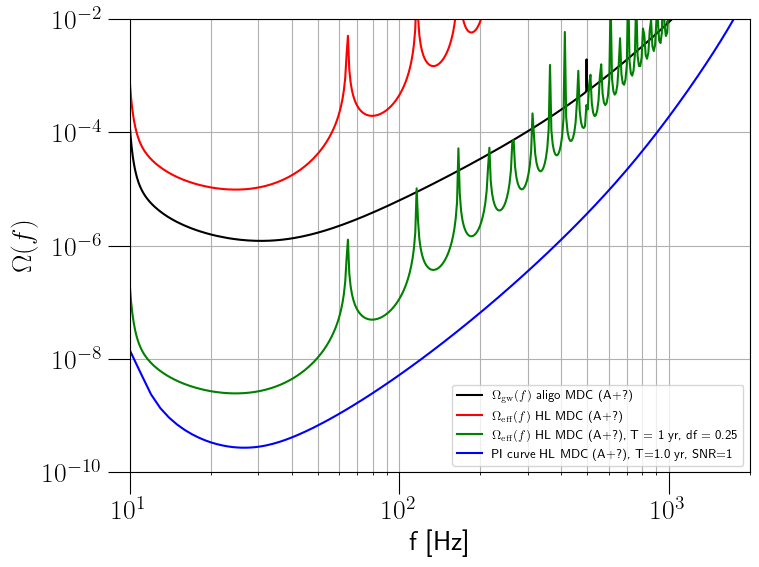

In [6]:
f, asd_H = np.transpose(np.loadtxt("aLIGO_MDC.txt"))
OM = 2*np.pi**2/(3*H0**2)*f**3*asd_H**2

plt.loglog(f, OM, label = r"$\Omega_{\rm gw}(f)$ aligo MDC (A+?)", color = "black")

ORFs_data = np.load("ORF_full_healpy_nside_128.npz")#("ORF_small_healpy_nside_32.npz")
f_ORF = ORFs_data["freqs"]
ORF_HL = ORFs_data["ORF_HL"]/5# to recover unnormalised orf

f_pi = np.linspace(10,2000, 1990+1)#np.linspace(1,1726, 1725*4+1)

asd_H_for_Om_eff = interp1d(f, asd_H, fill_value="extrapolate")(f_ORF)

S_HL_eff = np.power(ORF_HL**2/(asd_H_for_Om_eff**4), -0.5)
OM_eff_HL = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_HL_eff

plt.loglog(f_ORF, OM_eff_HL, label = r"$\Omega_{\rm eff}(f)$ HL MDC (A+?)", color = "red")
plt.loglog(f_ORF, OM_eff_HL/(np.sqrt(2*365.25*86400*0.25)), label = r"$\Omega_{\rm eff}(f)$ HL MDC (A+?), T = 1 yr, df = 0.25", color = "green")

OM_eff_HL_pi = interp1d(f_ORF, OM_eff_HL, fill_value="extrapolate")(f_pi)
year = 365.25*86400
obs_time = year
snr = 1
fref = 25.
PI_curve_HL, OM_betas, betas = np.transpose(PI_mine(f_pi, OM_eff_HL_pi, obs_time = obs_time, snr = snr, fref = fref))

#plt.vlines(fref, 1e-10,1e-2, color = "red", linestyle = "dashed", zorder=0, linewidth=1.5, alpha = 0.4)
plt.loglog(f_pi, PI_curve_HL, label = r"PI curve HL MDC (A+?), T={} yr, SNR={}".format(obs_time/year, str(snr)), color = "blue")

#for beta, OM_beta in zip(betas, OM_betas):
#    plt.loglog(f_pi, OM_beta*np.power(f_pi/fref, beta), color = "gray", zorder=-1 )
plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
plt.ylim(1e-10,1e-2)#plt.ylim(3e-11,1e-7)
plt.grid(which = "both")
plt.legend()
plt.show()

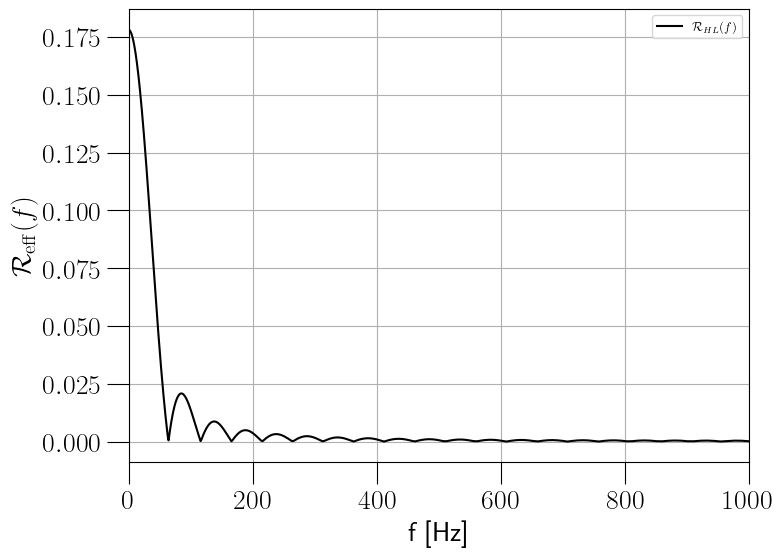

In [7]:
R_f_HL = np.sqrt(ORF_HL**2)

plt.plot(f_ORF, R_f_HL, color = "k", label = r"$\mathcal{R}_{HL}(f)$")
plt.xlabel("f [Hz]")
plt.ylabel(r"$\mathcal{R}_{\rm eff}(f)$")
plt.xlim(np.min(f_ORF), np.max(f_ORF))

plt.grid(which = "both")
plt.legend()
plt.show()

## Armageddon plot HL MDC

In [8]:
def PI_SNR(freqs, Om_eff, obs_time = 365.25*86400, snr = 1, fref = 25., beta = 2./3, Om_beta = 6.9e-10):
    """
    This function evaluates the SNR evolution with
    the observation time,assuming an fref, a power-law beta and Om_beta.
    Om_eff spectrum needs to be evaluated a prior,
    and it is assumed to be a linspace.
    """
    
    def integrand(beta):
        return ((freqs/fref)**(2*beta))/(Om_eff**2)
    
    snr_t = Om_beta*(np.sqrt(2*obs_time))*np.sqrt(np.trapz(integrand(beta), freqs))
    
    return(snr_t)

In [9]:
#After GW170817 paper: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.091101
obs_time = np.append(0, np.logspace(0, np.log10(year*5), 1000))
Om_beta = 1.8e-9
Om_beta_up_factor = (Om_beta+2.7e-9)/Om_beta
Om_beta_down_factor = (Om_beta-1.3e-9)/Om_beta
beta = 2./3
fref = 25.
#print(obs_time)
snr_t = PI_SNR(f_pi, OM_eff_HL_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#print(snr_t)

For a power law Om_beta(25.0)=1.8e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 0.23539247769833488 months of observation.
Reaching SNR = 3 after 0.17308208553213122 years of observation.
Reaching SNR = 5 after 0.48016583217710485 years of observation.

For a power law Om_beta(25.0)=4.500000000000001e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 0.03765159649751682 months of observation.
Reaching SNR = 3 after 0.3370636388579926 months of observation.
Reaching SNR = 5 after 0.9350848884868909 months of observation.



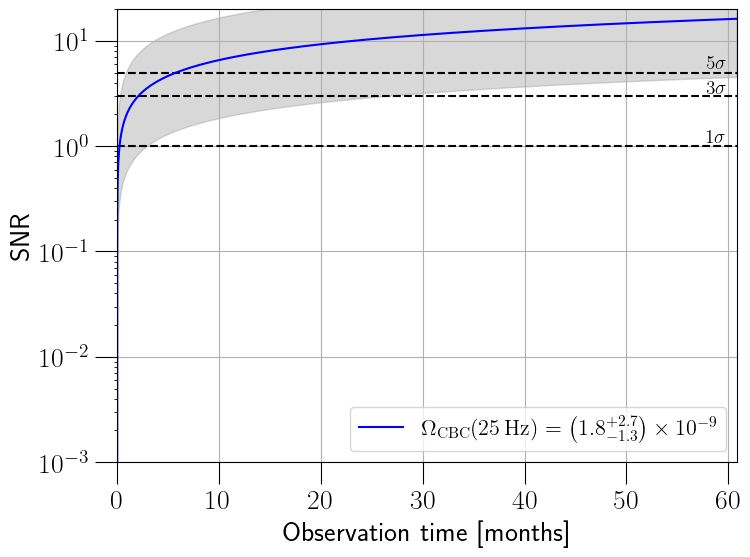

In [10]:
rescaled_obs_time = obs_time/86400/30

print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t>1])[0]} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t>3])[0]*30/365.25} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t>5])[0]*30/365.25} years of observation.\n")


print(f"For a power law Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>1])[0]} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>3])[0]} months of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>5])[0]} months of observation.\n")

plt.plot(rescaled_obs_time, snr_t, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(1.8^{+2.7}_{-1.3}\right)\times 10^{-9}$")
plt.fill_between(rescaled_obs_time, snr_t*Om_beta_up_factor, snr_t*Om_beta_down_factor, color = "gray", alpha = 0.3)
plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")

plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-2.pdf", bbox_inches = "tight")
plt.show()

In [11]:
obs_time = np.append(0, np.logspace(0, np.log10(86400*365.25*25), 1000))#86400*365.25#
Om_beta = 6.9e-10
Om_beta_up_factor = (Om_beta+3.0e-10)/Om_beta
Om_beta_down_factor = (Om_beta-2.1e-10)/Om_beta
beta = 2./3
#print(obs_time)
snr_t = PI_SNR(f_pi, OM_eff_HL_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#print(snr_t)

For a power law Om_beta(25.0)=6.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 1.5747008928988586 months of observation.
Reaching SNR = 3 after 1.1774798117274394 years of observation.
Reaching SNR = 5 after 3.2828494454126087 years of observation.

Optimistic scenario: Om_beta(25.0)=9.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 0.7682274591992482 months of observation.
Reaching SNR = 3 after 0.5744407259187854 years of observation.
Reaching SNR = 5 after 1.601558175114957 years of observation.


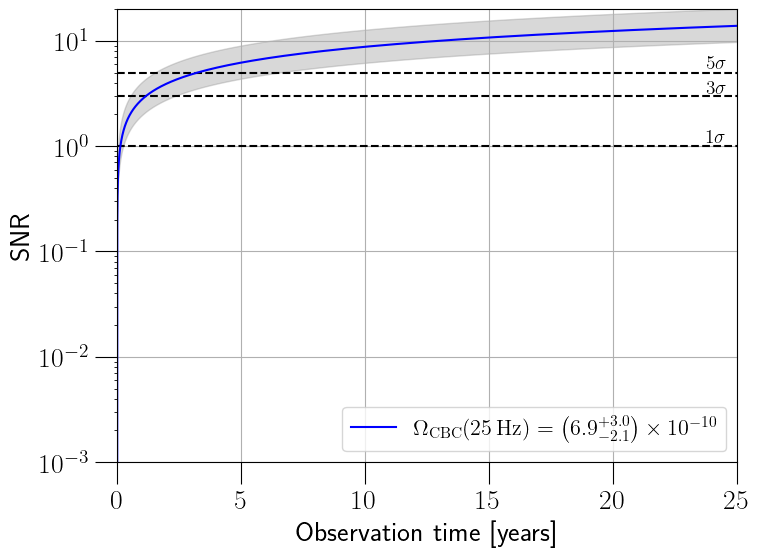

In [12]:
rescaled_obs_time = obs_time/86400/365.25

print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t>1])[0]*365.25/30.4375} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t>3])[0]} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t>5])[0]} years of observation.\n")

print(f"Optimistic scenario: Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>1])[0]*365.25/30.4375} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>3])[0]} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>5])[0]} years of observation.")


plt.plot(rescaled_obs_time, snr_t, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.fill_between(rescaled_obs_time, snr_t*Om_beta_up_factor, snr_t*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [years]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()

## Redo everything with public curves (20 January 2020)
https://dcc.ligo.org/LIGO-T1500293/public

### Public ASD files

In [13]:
path_to_det = "/home/delillo/Desktop/PhD/Detector_curves/"
detectors = ["aligo", "avirgo", "et", "ce"]
detectors_asds = {"aligo": path_to_det + "aligo.txt",\
                 "avirgo": path_to_det + "advirgo.txt",\
                 "et": path_to_det +"et_d.txt", \
                 "ce": path_to_det +"ce1.txt", "kagra": path_to_det+"kagra.txt",\
                 "aligo+":path_to_det + "aplus.txt",\
                 "avirgosqz":path_to_det + "advirgo_sqz.txt"}
colors = {"aligo": "blue", "avirgo": "red", "et" : "black", "ce": "purple", "kagra": "green"}

## HL Network

/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


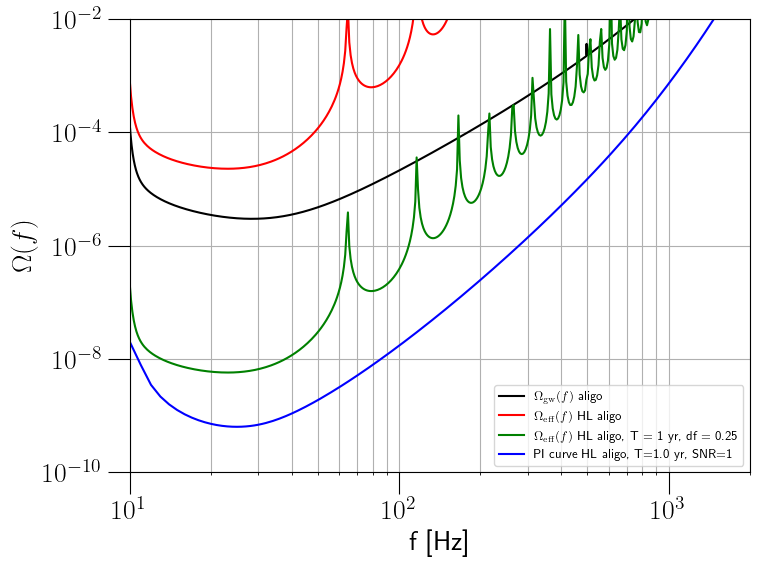

In [14]:
f, asd_H = np.transpose(np.loadtxt(detectors_asds["aligo"]))
OM = 2*np.pi**2/(3*H0**2)*f**3*asd_H**2

plt.loglog(f, OM, label = r"$\Omega_{\rm gw}(f)$ aligo", color = "black")

ORFs_data = np.load("ORF_full_healpy_nside_128.npz")#("ORF_small_healpy_nside_32.npz")
f_ORF = ORFs_data["freqs"]
ORF_HL = ORFs_data["ORF_HL"]/5# to recover unnormalised orf

f_pi = np.linspace(10,2000, 1990+1)#np.linspace(1,1726, 1725*4+1)

asd_H_for_Om_eff = interp1d(f, asd_H, fill_value="extrapolate")(f_ORF)

S_HL_eff = np.power(ORF_HL**2/(asd_H_for_Om_eff**4), -0.5)
OM_eff_HL = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_HL_eff

plt.loglog(f_ORF, OM_eff_HL, label = r"$\Omega_{\rm eff}(f)$ HL aligo", color = "red")
plt.loglog(f_ORF, OM_eff_HL/(np.sqrt(2*365.25*86400*0.25)), label = r"$\Omega_{\rm eff}(f)$ HL aligo, T = 1 yr, df = 0.25", color = "green")

OM_eff_HL_pi = interp1d(f_ORF, OM_eff_HL, fill_value="extrapolate")(f_pi)
year = 365.25*86400
obs_time = year
snr = 1
fref = 25.
PI_curve_HL, OM_betas, betas = np.transpose(PI_mine(f_pi, OM_eff_HL_pi, obs_time = obs_time, snr = snr, fref = fref))

#plt.vlines(fref, 1e-10,1e-2, color = "red", linestyle = "dashed", zorder=0, linewidth=1.5, alpha = 0.4)
plt.loglog(f_pi, PI_curve_HL, label = r"PI curve HL aligo, T={} yr, SNR={}".format(obs_time/year, str(snr)), color = "blue")

#for beta, OM_beta in zip(betas, OM_betas):
#    plt.loglog(f_pi, OM_beta*np.power(f_pi/fref, beta), color = "gray", zorder=-1 )
plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
plt.ylim(1e-10,1e-2)#plt.ylim(3e-11,1e-7)
plt.grid(which = "both")
plt.legend()
plt.show()

In [15]:
#After GW170817 paper: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.091101
obs_time = np.append(0, np.logspace(0, np.log10(year*5), 1000))
Om_beta = 1.8e-9
Om_beta_up_factor = (Om_beta+2.7e-9)/Om_beta
Om_beta_down_factor = (Om_beta-1.3e-9)/Om_beta
beta = 2./3
fref = 25.
#print(obs_time)
snr_t = PI_SNR(f_pi, OM_eff_HL_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#print(snr_t)

For a power law Om_beta(25.0)=1.8e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 1.3905381995400115 months of observation.
Reaching SNR = 3 after 1.0224509038768748 years of observation.
Reaching SNR = 5 after 2.8364922205027017 years of observation.

For a power law Om_beta(25.0)=4.500000000000001e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 0.22241995035440457 months of observation.
Reaching SNR = 3 after 1.9911420708551943 months of observation.
Reaching SNR = 5 after 5.523843709738175 months of observation.



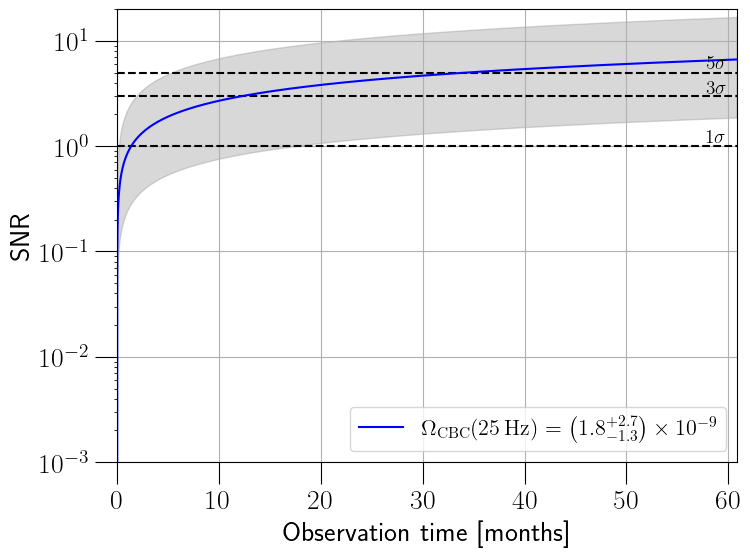

In [16]:
rescaled_obs_time = obs_time/86400/30

print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t>1])[0]} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t>3])[0]*30/365.25} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t>5])[0]*30/365.25} years of observation.\n")


print(f"For a power law Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>1])[0]} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>3])[0]} months of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>5])[0]} months of observation.\n")

plt.plot(rescaled_obs_time, snr_t, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(1.8^{+2.7}_{-1.3}\right)\times 10^{-9}$")
plt.fill_between(rescaled_obs_time, snr_t*Om_beta_up_factor, snr_t*Om_beta_down_factor, color = "gray", alpha = 0.3)
plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")

plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
plt.savefig("Predicting_Armageddon_plot_HL_design_GWTC-2.pdf", bbox_inches = "tight")
plt.show()

In [17]:
obs_time = np.append(0, np.logspace(0, np.log10(86400*365.25*25), 1000))#86400*365.25#
Om_beta = 6.9e-10
Om_beta_up_factor = (Om_beta+3.0e-10)/Om_beta
Om_beta_down_factor = (Om_beta-2.1e-10)/Om_beta
beta = 2./3
fref = 25.
#print(obs_time)
snr_t = PI_SNR(f_pi, OM_eff_HL_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#print(snr_t)

For a power law Om_beta(25.0)=6.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 9.375959382585094 months of observation.
Reaching SNR = 3 after 7.010857070289017 years of observation.
Reaching SNR = 5 after 19.546482254587456 years of observation.

Optimistic scenario: Om_beta(25.0)=9.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 4.4812742168993696 months of observation.
Reaching SNR = 3 after 3.4202894900264464 years of observation.
Reaching SNR = 5 after 9.342312971327427 years of observation.


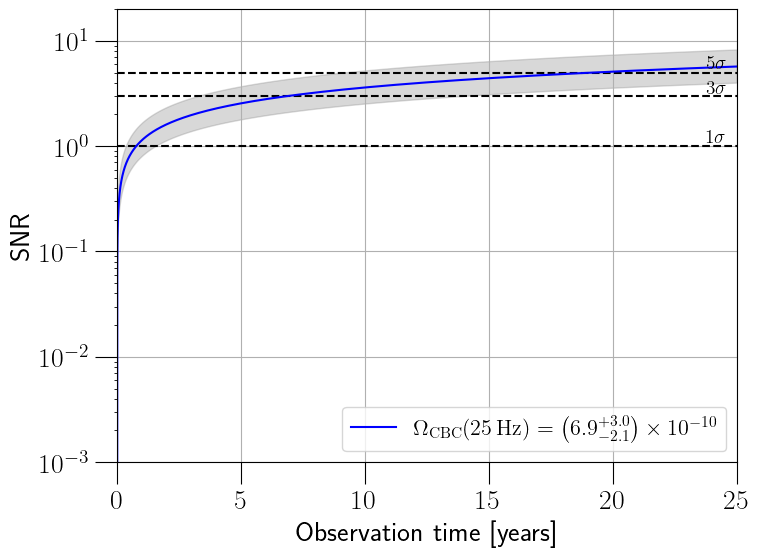

In [18]:
rescaled_obs_time = obs_time/86400/365.25

print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t>1])[0]*365.25/30.4375} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t>3])[0]} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t>5])[0]} years of observation.\n")

print(f"Optimistic scenario: Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>1])[0]*365.25/30.4375} months of observation.")
print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>3])[0]} years of observation.")
print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t*Om_beta_up_factor>5])[0]} years of observation.")


plt.plot(rescaled_obs_time, snr_t, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.fill_between(rescaled_obs_time, snr_t*Om_beta_up_factor, snr_t*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [years]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
plt.savefig("Predicting_Armageddon_plot_HL_design_GWTC-3.pdf", bbox_inches = "tight")
plt.show()

## HLV network

/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with diff

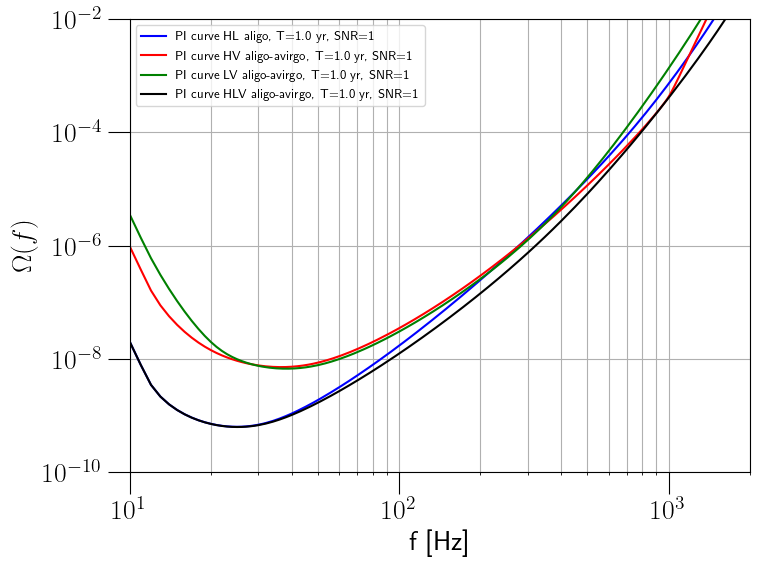

In [19]:
f, asd_H = np.transpose(np.loadtxt(detectors_asds["aligo"]))

ORFs_data = np.load("ORF_full_healpy_nside_128.npz")#("ORF_small_healpy_nside_32.npz")
f_ORF = ORFs_data["freqs"]
ORF_HL = ORFs_data["ORF_HL"]/5# to recover unnormalised orf

f_pi = np.linspace(10,2000, 1990+1)#np.linspace(1,1726, 1725*4+1)

asd_H_for_Om_eff = interp1d(f, asd_H, fill_value="extrapolate")(f_ORF)

S_HL_eff = np.power(ORF_HL**2/(asd_H_for_Om_eff**4), -0.5)
OM_eff_HL = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_HL_eff

OM_eff_HL_pi = interp1d(f_ORF, OM_eff_HL, fill_value="extrapolate")(f_pi)
year = 365.25*86400
obs_time = year
snr = 1
fref = 25.
PI_curve_HL, OM_betas, betas = np.transpose(PI_mine(f_pi, OM_eff_HL_pi, obs_time = obs_time, snr = snr, fref = fref))

#plt.vlines(fref, 1e-10,1e-2, color = "red", linestyle = "dashed", zorder=0, linewidth=1.5, alpha = 0.4)
plt.loglog(f_pi, PI_curve_HL, label = r"PI curve HL aligo, T={} yr, SNR={}".format(obs_time/year, str(snr)), color = "blue")
#for beta, OM_beta in zip(betas, OM_betas):
#    plt.loglog(f_pi, OM_beta*np.power(f_pi/fref, beta), color = "gray", zorder=-1 )



f, asd_V = np.transpose(np.loadtxt(detectors_asds["avirgo"]))
ORF_HV = ORFs_data["ORF_HV"]/5# to recover unnormalised orf
ORF_LV = ORFs_data["ORF_LV"]/5# to recover unnormalised orf

asd_V_for_Om_eff = interp1d(f, asd_V, fill_value="extrapolate")(f_ORF)

S_HV_eff = np.power(ORF_HV**2/(np.square(asd_H_for_Om_eff)*np.square(asd_V_for_Om_eff)), -0.5)
OM_eff_HV = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_HV_eff

OM_eff_HV_pi = interp1d(f_ORF, OM_eff_HV, fill_value="extrapolate")(f_pi)

PI_curve_HV, _, _ = np.transpose(PI_mine(f_pi, OM_eff_HV_pi, obs_time = obs_time, snr = snr, fref = fref))

plt.loglog(f_pi, PI_curve_HV, label = r"PI curve HV aligo-avirgo, T={} yr, SNR={}".format(obs_time/year, str(snr)), color = "red")


S_LV_eff = np.power(ORF_LV**2/(np.square(asd_H_for_Om_eff)*np.square(asd_V_for_Om_eff)), -0.5)
OM_eff_LV = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_LV_eff

OM_eff_LV_pi = interp1d(f_ORF, OM_eff_LV, fill_value="extrapolate")(f_pi)

PI_curve_LV, _, _ = np.transpose(PI_mine(f_pi, OM_eff_LV_pi, obs_time = obs_time, snr = snr, fref = fref))

plt.loglog(f_pi, PI_curve_LV, label = r"PI curve LV aligo-avirgo, T={} yr, SNR={}".format(obs_time/year, str(snr)), color = "green")

S_eff_array = [ORF_HL**2/asd_H_for_Om_eff**4,\
               ORF_HV**2/(np.square(asd_H_for_Om_eff)*np.square(asd_V_for_Om_eff)),\
               ORF_LV**2/(np.square(asd_H_for_Om_eff)*np.square(asd_V_for_Om_eff))]

S_HLV_eff = np.power(np.sum(S_eff_array, axis = 0), -0.5)
OM_eff_HLV = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_HLV_eff

OM_eff_HLV_pi = interp1d(f_ORF, OM_eff_HLV, fill_value="extrapolate")(f_pi)

PI_curve_HLV, _, _ = np.transpose(PI_mine(f_pi, OM_eff_HLV_pi, obs_time = obs_time, snr = snr, fref = fref))

plt.loglog(f_pi, PI_curve_HLV, label = r"PI curve HLV aligo-avirgo, T={} yr, SNR={}".format(obs_time/year, str(snr)), color = "black")



plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
plt.ylim(1e-10,1e-2)#plt.ylim(3e-11,1e-7)
plt.grid(which = "both")
plt.legend()
plt.show()

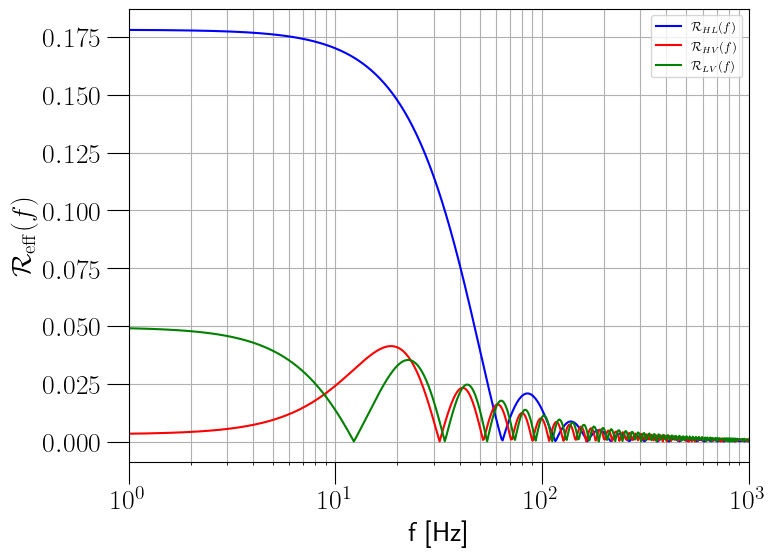

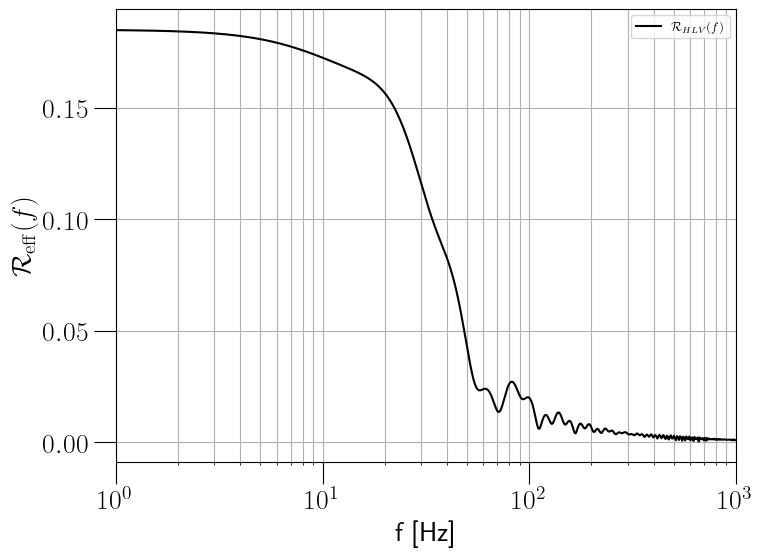

In [20]:
ORF_array = [ORF_HL, ORF_HV, ORF_LV]

R_f_HL = np.sqrt(ORF_HL**2)
R_f_HV = np.sqrt(ORF_HV**2)
R_f_LV = np.sqrt(ORF_LV**2)
R_f_HLV = np.sqrt(np.sum(np.square(ORF_array), axis = 0))

plt.plot(f_ORF, R_f_HL, color = "blue", label = r"$\mathcal{R}_{HL}(f)$")
plt.plot(f_ORF, R_f_HV, color = "red", label = r"$\mathcal{R}_{HV}(f)$")
plt.plot(f_ORF, R_f_LV, color = "green", label = r"$\mathcal{R}_{LV}(f)$")
                  
plt.xscale("log")
plt.xlabel("f [Hz]")
plt.ylabel(r"$\mathcal{R}_{\rm eff}(f)$")
plt.xlim(1, np.max(f_ORF))

plt.grid(which = "both")
plt.legend()
plt.show()
plt.close()

plt.plot(f_ORF, R_f_HLV, color = "black", label = r"$\mathcal{R}_{HLV}(f)$")
plt.xscale("log")
plt.xlabel("f [Hz]")
plt.ylabel(r"$\mathcal{R}_{\rm eff}(f)$")
plt.xlim(1, np.max(f_ORF))

plt.grid(which = "both")
plt.legend()
plt.show()
plt.close()

In [21]:
#After GW170817 paper: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.091101
obs_time = np.append(0, np.logspace(0, np.log10(year*5), 1000))
Om_beta = 1.8e-9
Om_beta_up_factor = (Om_beta+2.7e-9)/Om_beta
Om_beta_down_factor = (Om_beta-1.3e-9)/Om_beta
beta = 2./3
fref = 25.
#print(obs_time)
snr_t_HL = PI_SNR(f_pi, OM_eff_HL_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
snr_t_HV = PI_SNR(f_pi, OM_eff_HV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
snr_t_LV = PI_SNR(f_pi, OM_eff_LV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
snr_t_HLV = PI_SNR(f_pi, OM_eff_HLV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)


#print(snr_t)

For a power law Om_beta(25.0)=1.8e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 1.3905381995400115 months of observation.
Reaching SNR = 3 after 1.0224509038768748 years of observation.
Reaching SNR = 5 after 2.8364922205027017 years of observation.

For a power law Om_beta(25.0)=4.500000000000001e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 0.22241995035440457 months of observation.
Reaching SNR = 3 after 1.9911420708551943 months of observation.
Reaching SNR = 5 after 5.523843709738175 months of observation.



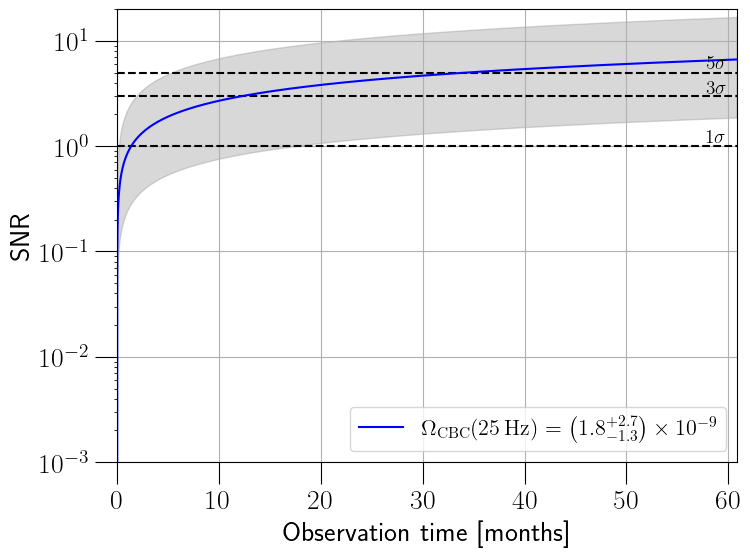

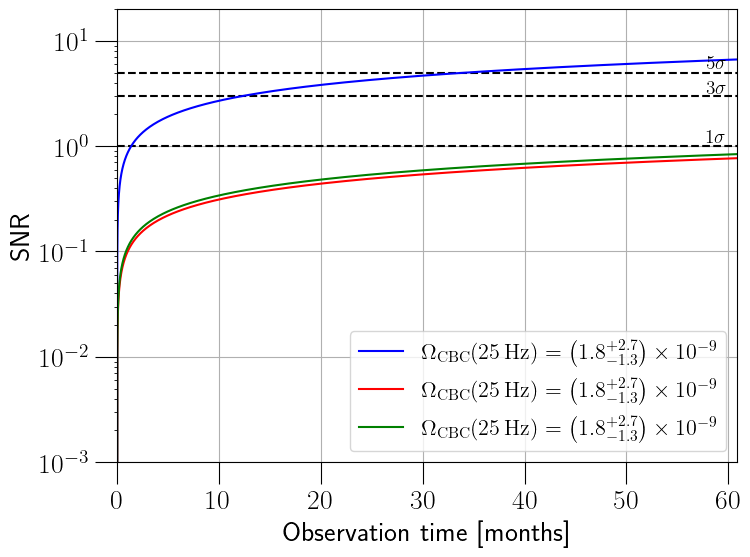

HLV
For a power law Om_beta(25.0)=1.8e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 1.3389685101086013 months of observation.
Reaching SNR = 3 after 1.003312407373952 years of observation.
Reaching SNR = 5 after 2.783398036481915 years of observation.

For a power law Om_beta(25.0)=4.500000000000001e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 0.21417125372246695 months of observation.
Reaching SNR = 3 after 1.9538713663006868 months of observation.
Reaching SNR = 5 after 5.420446995900222 months of observation.



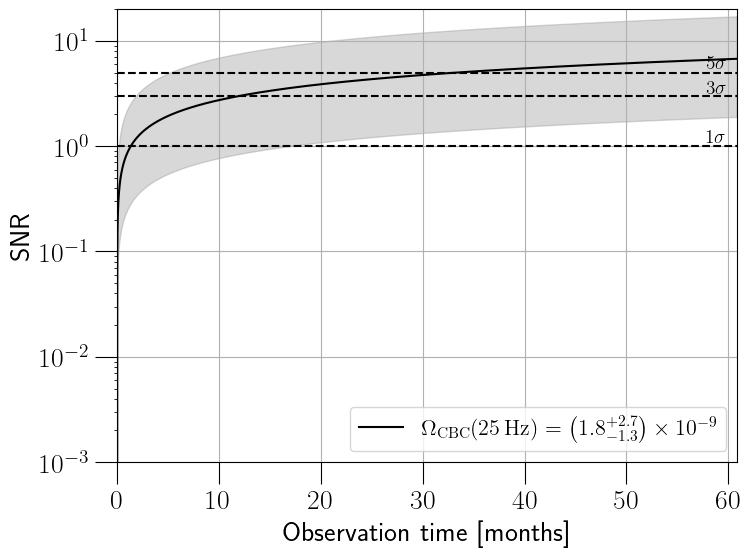

In [22]:
rescaled_obs_time = obs_time/86400/30

print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HL>1])[0]} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HL>3])[0]*30/365.25} years of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HL>5])[0]*30/365.25} years of observation.\n")
except IndexError:
    pass

print(f"For a power law Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HL*Om_beta_up_factor>1])[0]} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HL*Om_beta_up_factor>3])[0]} months of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HL*Om_beta_up_factor>5])[0]} months of observation.\n")
except IndexError:
    pass
    
    
plt.plot(rescaled_obs_time, snr_t_HL, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(1.8^{+2.7}_{-1.3}\right)\times 10^{-9}$")
plt.fill_between(rescaled_obs_time, snr_t_HL*Om_beta_up_factor, snr_t_HL*Om_beta_down_factor, color = "gray", alpha = 0.3)
plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")

plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-2.pdf", bbox_inches = "tight")
plt.show()
plt.close()



plt.plot(rescaled_obs_time, snr_t_HL, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(1.8^{+2.7}_{-1.3}\right)\times 10^{-9}$")
#plt.fill_between(rescaled_obs_time, snr_t_HL*Om_beta_up_factor, snr_t_HL*Om_beta_down_factor, color = "gray", alpha = 0.3)
plt.plot(rescaled_obs_time, snr_t_HV, color = "red", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(1.8^{+2.7}_{-1.3}\right)\times 10^{-9}$")
plt.plot(rescaled_obs_time, snr_t_LV, color = "green", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(1.8^{+2.7}_{-1.3}\right)\times 10^{-9}$")

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")

plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-2.pdf", bbox_inches = "tight")
plt.show()
plt.close()



print("HLV")
print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HLV>1])[0]} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HLV>3])[0]*30/365.25} years of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HLV>5])[0]*30/365.25} years of observation.\n")
except IndexError:
    pass

print(f"For a power law Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HLV*Om_beta_up_factor>1])[0]} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HLV*Om_beta_up_factor>3])[0]} months of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HLV*Om_beta_up_factor>5])[0]} months of observation.\n")
except IndexError:
    pass
    
plt.plot(rescaled_obs_time, snr_t_HLV, color = "black", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(1.8^{+2.7}_{-1.3}\right)\times 10^{-9}$")
plt.fill_between(rescaled_obs_time, snr_t_HLV*Om_beta_up_factor, snr_t_HLV*Om_beta_down_factor, color = "gray", alpha = 0.3)
plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")

plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-2.pdf", bbox_inches = "tight")
plt.show()
plt.close()

In [23]:
obs_time = np.append(0, np.logspace(0, np.log10(86400*365.25*25), 1000))#86400*365.25#
Om_beta = 6.9e-10
Om_beta_up_factor = (Om_beta+3.0e-10)/Om_beta
Om_beta_down_factor = (Om_beta-2.1e-10)/Om_beta
beta = 2./3
fref = 25.
#print(obs_time)
snr_t_HL = PI_SNR(f_pi, OM_eff_HL_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
snr_t_HV = PI_SNR(f_pi, OM_eff_HV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
snr_t_LV = PI_SNR(f_pi, OM_eff_LV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
snr_t_HLV = PI_SNR(f_pi, OM_eff_HLV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#print(snr_t)

For a power law Om_beta(25.0)=6.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 9.375959382585094 months of observation.
Reaching SNR = 3 after 7.010857070289017 years of observation.
Reaching SNR = 5 after 19.546482254587456 years of observation.

Optimistic scenario: Om_beta(25.0)=9.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 4.4812742168993696 months of observation.
Reaching SNR = 3 after 3.4202894900264464 years of observation.
Reaching SNR = 5 after 9.342312971327427 years of observation.


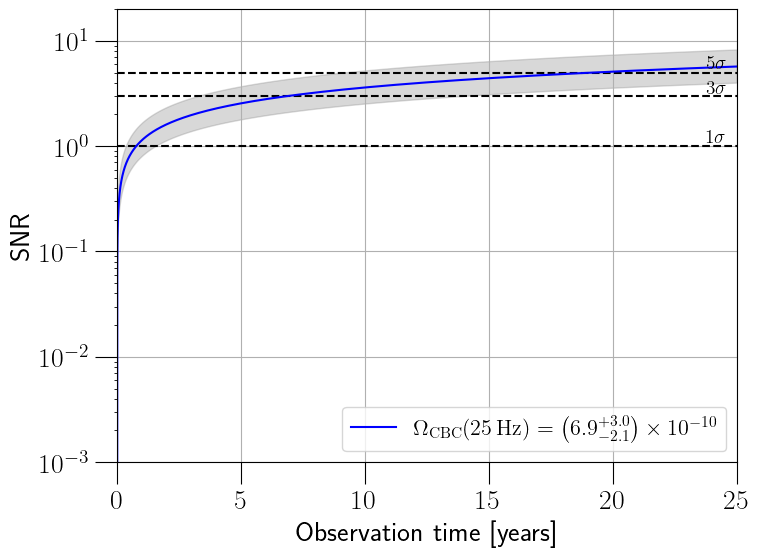

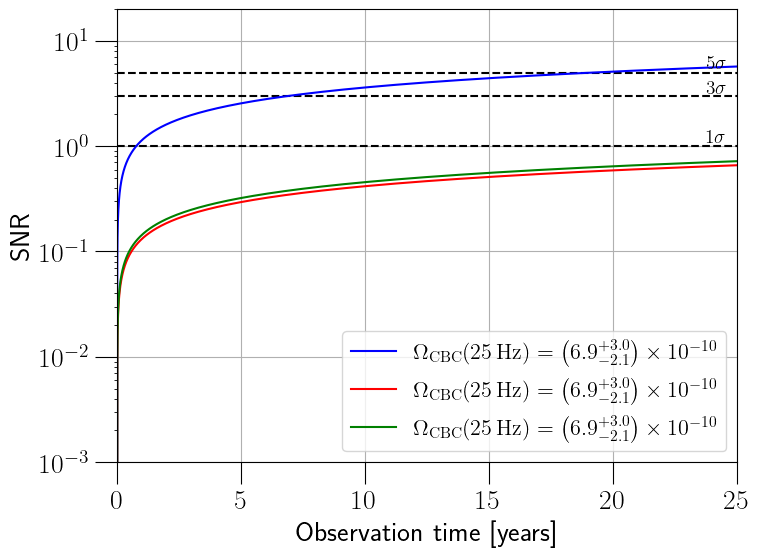

HLV
For a power law Om_beta(25.0)=6.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 8.999198210877921 months of observation.
Reaching SNR = 3 after 6.729134569509029 years of observation.
Reaching SNR = 5 after 18.761031373617342 years of observation.

Optimistic scenario: Om_beta(25.0)=9.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 4.390313873288195 months of observation.
Reaching SNR = 3 after 3.2828494454126087 years of observation.
Reaching SNR = 5 after 9.152683871016968 years of observation.


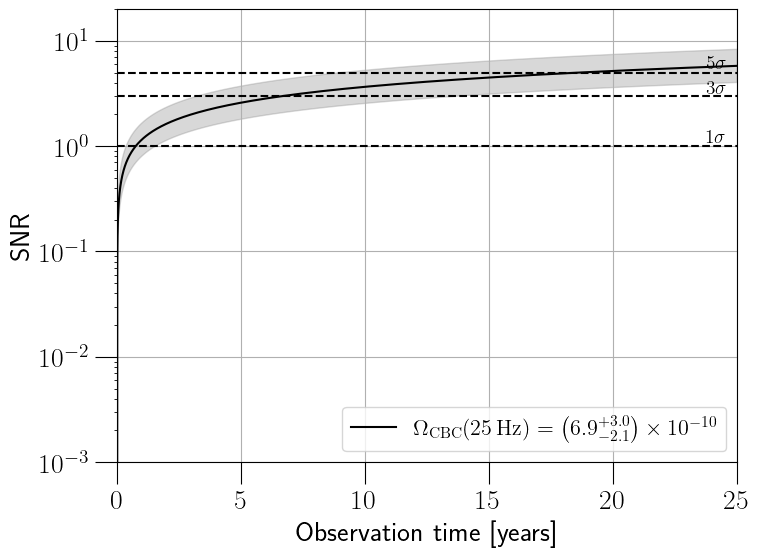

In [24]:
rescaled_obs_time = obs_time/86400/365.25

print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HL>1])[0]*365.25/30.4375} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HL>3])[0]} years of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HL>5])[0]} years of observation.\n")
except IndexError:
    pass
    
print(f"Optimistic scenario: Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HL*Om_beta_up_factor>1])[0]*365.25/30.4375} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HL*Om_beta_up_factor>3])[0]} years of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HL*Om_beta_up_factor>5])[0]} years of observation.")
except IndexError:
    pass

plt.plot(rescaled_obs_time, snr_t_HL, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.fill_between(rescaled_obs_time, snr_t_HL*Om_beta_up_factor, snr_t_HL*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [years]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()
plt.close()

plt.plot(rescaled_obs_time, snr_t_HL, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
#plt.fill_between(rescaled_obs_time, snr_t*Om_beta_up_factor, snr_t_HL*Om_beta_down_factor, color = "gray", alpha = 0.3)
plt.plot(rescaled_obs_time, snr_t_HV, color = "red", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.plot(rescaled_obs_time, snr_t_LV, color = "green", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")


plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [years]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()
plt.close()


print("HLV")
print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HLV>1])[0]*365.25/30.4375} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HLV>3])[0]} years of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HLV>5])[0]} years of observation.\n")
except IndexError:
    pass

print(f"Optimistic scenario: Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HLV*Om_beta_up_factor>1])[0]*365.25/30.4375} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HLV*Om_beta_up_factor>3])[0]} years of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HLV*Om_beta_up_factor>5])[0]} years of observation.")
except IndexError:
    pass

plt.plot(rescaled_obs_time, snr_t_HLV, color = "black", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.fill_between(rescaled_obs_time, snr_t_HLV*Om_beta_up_factor, snr_t_HLV*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [years]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()
plt.close()

## HLV network - A+ Virgo squeezed

/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with diff

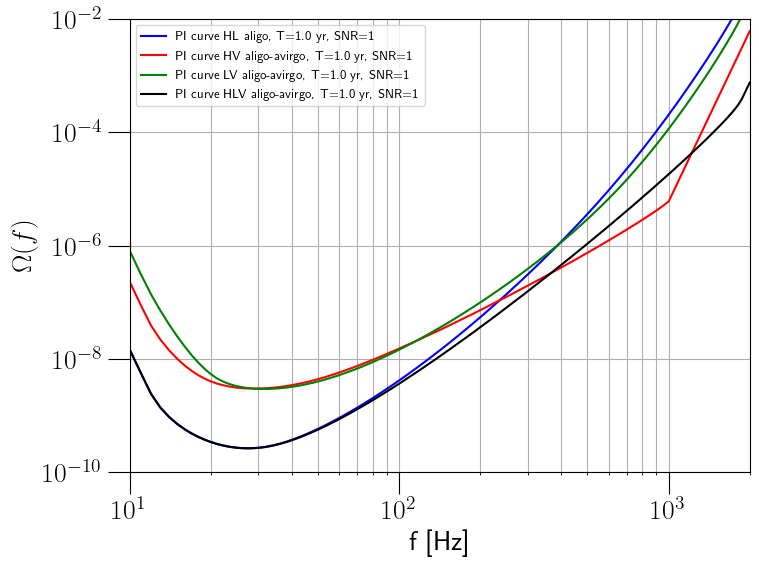

In [25]:
f, asd_H = np.transpose(np.loadtxt(detectors_asds["aligo+"]))

ORFs_data = np.load("ORF_full_healpy_nside_128.npz")#("ORF_small_healpy_nside_32.npz")
f_ORF = ORFs_data["freqs"]
ORF_HL = ORFs_data["ORF_HL"]/5# to recover unnormalised orf

f_pi = np.linspace(10,2000, 1990+1)#np.linspace(1,1726, 1725*4+1)

asd_H_for_Om_eff = interp1d(f, asd_H, fill_value="extrapolate")(f_ORF)

S_HL_eff = np.power(ORF_HL**2/(asd_H_for_Om_eff**4), -0.5)
OM_eff_HL = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_HL_eff

OM_eff_HL_pi = interp1d(f_ORF, OM_eff_HL, fill_value="extrapolate")(f_pi)
year = 365.25*86400
obs_time = year
snr = 1
fref = 25.
PI_curve_HL, OM_betas, betas = np.transpose(PI_mine(f_pi, OM_eff_HL_pi, obs_time = obs_time, snr = snr, fref = fref))

#plt.vlines(fref, 1e-10,1e-2, color = "red", linestyle = "dashed", zorder=0, linewidth=1.5, alpha = 0.4)
plt.loglog(f_pi, PI_curve_HL, label = r"PI curve HL aligo, T={} yr, SNR={}".format(obs_time/year, str(snr)), color = "blue")
#for beta, OM_beta in zip(betas, OM_betas):
#    plt.loglog(f_pi, OM_beta*np.power(f_pi/fref, beta), color = "gray", zorder=-1 )



f, asd_V = np.transpose(np.loadtxt(detectors_asds["avirgosqz"]))
ORF_HV = ORFs_data["ORF_HV"]/5# to recover unnormalised orf
ORF_LV = ORFs_data["ORF_LV"]/5# to recover unnormalised orf

asd_V_for_Om_eff = interp1d(f, asd_V, fill_value="extrapolate")(f_ORF)

S_HV_eff = np.power(ORF_HV**2/(np.square(asd_H_for_Om_eff)*np.square(asd_V_for_Om_eff)), -0.5)
OM_eff_HV = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_HV_eff

OM_eff_HV_pi = interp1d(f_ORF, OM_eff_HV, fill_value="extrapolate")(f_pi)

PI_curve_HV, _, _ = np.transpose(PI_mine(f_pi, OM_eff_HV_pi, obs_time = obs_time, snr = snr, fref = fref))

plt.loglog(f_pi, PI_curve_HV, label = r"PI curve HV aligo-avirgo, T={} yr, SNR={}".format(obs_time/year, str(snr)), color = "red")


S_LV_eff = np.power(ORF_LV**2/(np.square(asd_H_for_Om_eff)*np.square(asd_V_for_Om_eff)), -0.5)
OM_eff_LV = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_LV_eff

OM_eff_LV_pi = interp1d(f_ORF, OM_eff_LV, fill_value="extrapolate")(f_pi)

PI_curve_LV, _, _ = np.transpose(PI_mine(f_pi, OM_eff_LV_pi, obs_time = obs_time, snr = snr, fref = fref))

plt.loglog(f_pi, PI_curve_LV, label = r"PI curve LV aligo-avirgo, T={} yr, SNR={}".format(obs_time/year, str(snr)), color = "green")

S_eff_array = [ORF_HL**2/asd_H_for_Om_eff**4,\
               ORF_HV**2/(np.square(asd_H_for_Om_eff)*np.square(asd_V_for_Om_eff)),\
               ORF_LV**2/(np.square(asd_H_for_Om_eff)*np.square(asd_V_for_Om_eff))]

S_HLV_eff = np.power(np.sum(S_eff_array, axis = 0), -0.5)
OM_eff_HLV = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_HLV_eff

OM_eff_HLV_pi = interp1d(f_ORF, OM_eff_HLV, fill_value="extrapolate")(f_pi)

PI_curve_HLV, _, _ = np.transpose(PI_mine(f_pi, OM_eff_HLV_pi, obs_time = obs_time, snr = snr, fref = fref))

plt.loglog(f_pi, PI_curve_HLV, label = r"PI curve HLV aligo-avirgo, T={} yr, SNR={}".format(obs_time/year, str(snr)), color = "black")



plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
plt.ylim(1e-10,1e-2)#plt.ylim(3e-11,1e-7)
plt.grid(which = "both")
plt.legend()
plt.show()

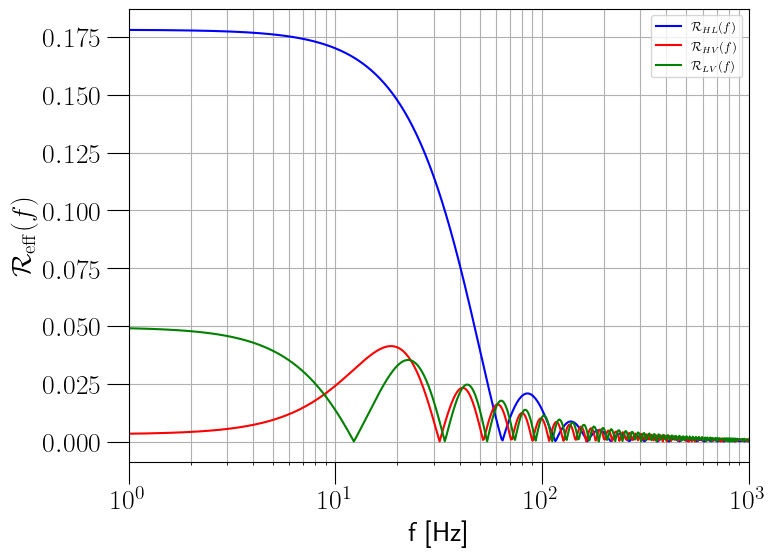

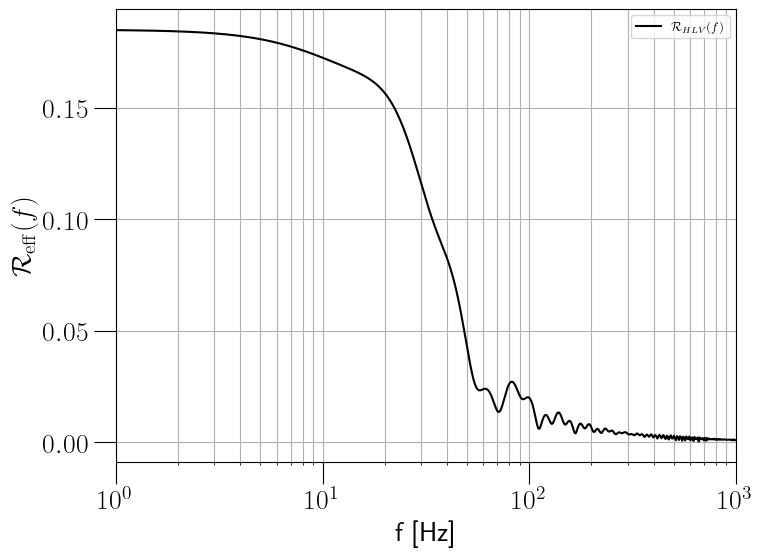

In [26]:
ORF_array = [ORF_HL, ORF_HV, ORF_LV]

R_f_HL = np.sqrt(ORF_HL**2)
R_f_HV = np.sqrt(ORF_HV**2)
R_f_LV = np.sqrt(ORF_LV**2)
R_f_HLV = np.sqrt(np.sum(np.square(ORF_array), axis = 0))

plt.plot(f_ORF, R_f_HL, color = "blue", label = r"$\mathcal{R}_{HL}(f)$")
plt.plot(f_ORF, R_f_HV, color = "red", label = r"$\mathcal{R}_{HV}(f)$")
plt.plot(f_ORF, R_f_LV, color = "green", label = r"$\mathcal{R}_{LV}(f)$")
                  
plt.xscale("log")
plt.xlabel("f [Hz]")
plt.ylabel(r"$\mathcal{R}_{\rm eff}(f)$")
plt.xlim(1, np.max(f_ORF))

plt.grid(which = "both")
plt.legend()
plt.show()
plt.close()

plt.plot(f_ORF, R_f_HLV, color = "black", label = r"$\mathcal{R}_{HLV}(f)$")
plt.xscale("log")
plt.xlabel("f [Hz]")
plt.ylabel(r"$\mathcal{R}_{\rm eff}(f)$")
plt.xlim(1, np.max(f_ORF))

plt.grid(which = "both")
plt.legend()
plt.show()
plt.close()

In [27]:
#After GW170817 paper: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.091101
obs_time = np.append(0, np.logspace(0, np.log10(year*5), 1000))
Om_beta = 1.8e-9
Om_beta_up_factor = (Om_beta+2.7e-9)/Om_beta
Om_beta_down_factor = (Om_beta-1.3e-9)/Om_beta
beta = 2./3
fref = 25.
#print(obs_time)
snr_t_HL = PI_SNR(f_pi, OM_eff_HL_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
snr_t_HV = PI_SNR(f_pi, OM_eff_HV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
snr_t_LV = PI_SNR(f_pi, OM_eff_LV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
snr_t_HLV = PI_SNR(f_pi, OM_eff_HLV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)


#print(snr_t)

For a power law Om_beta(25.0)=1.8e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 0.21417125372246695 months of observation.
Reaching SNR = 3 after 0.15747830014696357 years of observation.
Reaching SNR = 5 after 0.4452112522299977 years of observation.

For a power law Om_beta(25.0)=4.500000000000001e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 0.03425721036362016 months of observation.
Reaching SNR = 3 after 0.3066765039577293 months of observation.
Reaching SNR = 5 after 0.8670136153941167 months of observation.



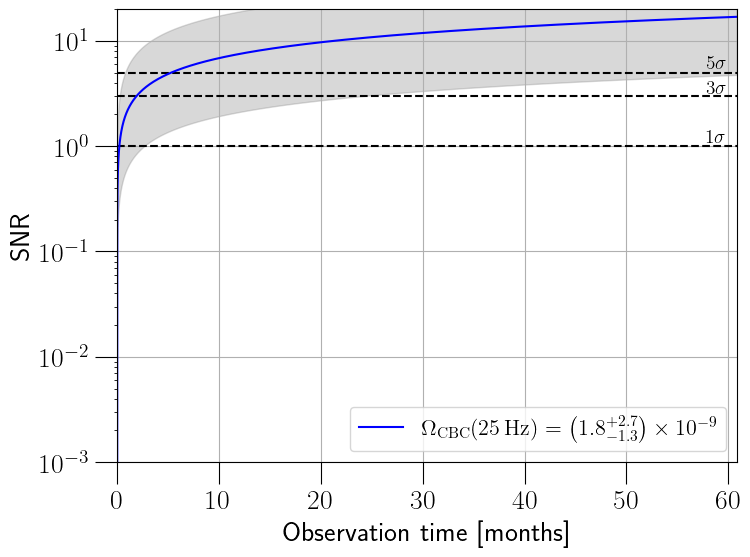

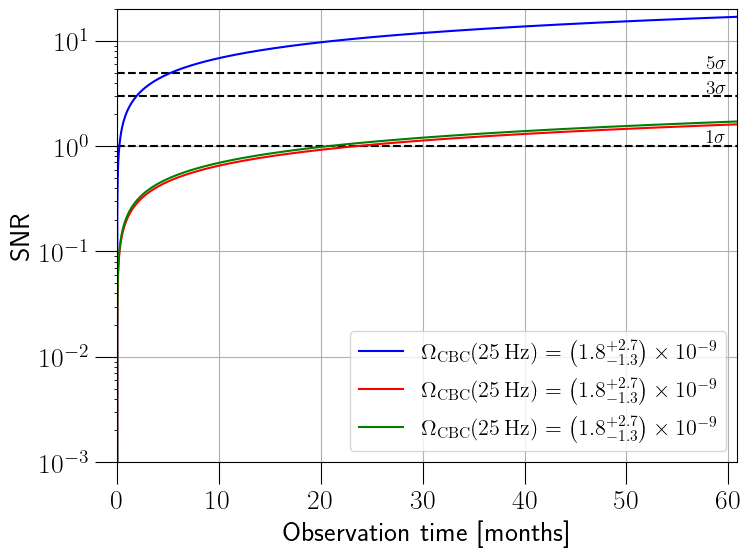

HLV
For a power law Om_beta(25.0)=1.8e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 0.21016234163206543 months of observation.
Reaching SNR = 3 after 0.15453058120493818 years of observation.
Reaching SNR = 5 after 0.42870008697293016 years of observation.

For a power law Om_beta(25.0)=4.500000000000001e-09 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 0.03361597517251412 months of observation.
Reaching SNR = 3 after 0.3009360550263737 months of observation.
Reaching SNR = 5 after 0.8507846336569117 months of observation.



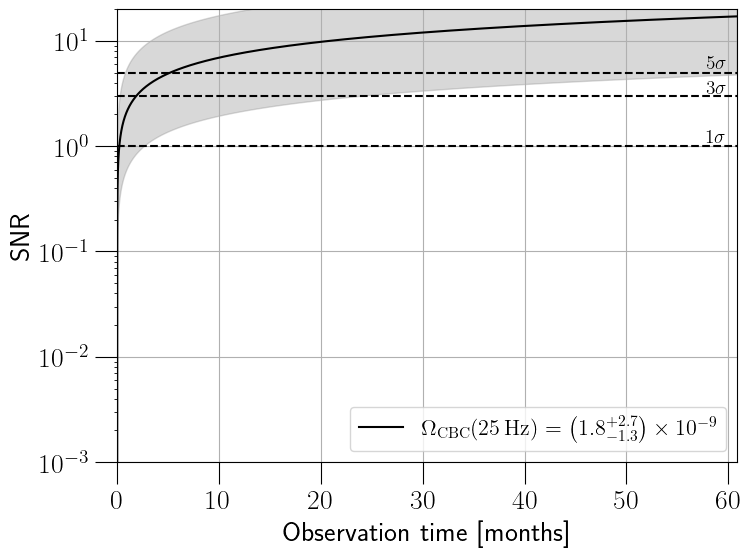

In [28]:
rescaled_obs_time = obs_time/86400/30

print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HL>1])[0]} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HL>3])[0]*30/365.25} years of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HL>5])[0]*30/365.25} years of observation.\n")
except IndexError:
    pass

print(f"For a power law Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HL*Om_beta_up_factor>1])[0]} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HL*Om_beta_up_factor>3])[0]} months of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HL*Om_beta_up_factor>5])[0]} months of observation.\n")
except IndexError:
    pass
    
    
plt.plot(rescaled_obs_time, snr_t_HL, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(1.8^{+2.7}_{-1.3}\right)\times 10^{-9}$")
plt.fill_between(rescaled_obs_time, snr_t_HL*Om_beta_up_factor, snr_t_HL*Om_beta_down_factor, color = "gray", alpha = 0.3)
plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")

plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-2.pdf", bbox_inches = "tight")
plt.show()
plt.close()



plt.plot(rescaled_obs_time, snr_t_HL, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(1.8^{+2.7}_{-1.3}\right)\times 10^{-9}$")
#plt.fill_between(rescaled_obs_time, snr_t_HL*Om_beta_up_factor, snr_t_HL*Om_beta_down_factor, color = "gray", alpha = 0.3)
plt.plot(rescaled_obs_time, snr_t_HV, color = "red", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(1.8^{+2.7}_{-1.3}\right)\times 10^{-9}$")
plt.plot(rescaled_obs_time, snr_t_LV, color = "green", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(1.8^{+2.7}_{-1.3}\right)\times 10^{-9}$")

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")

plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-2.pdf", bbox_inches = "tight")
plt.show()
plt.close()



print("HLV")
print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HLV>1])[0]} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HLV>3])[0]*30/365.25} years of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HLV>5])[0]*30/365.25} years of observation.\n")
except IndexError:
    pass

print(f"For a power law Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HLV*Om_beta_up_factor>1])[0]} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HLV*Om_beta_up_factor>3])[0]} months of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HLV*Om_beta_up_factor>5])[0]} months of observation.\n")
except IndexError:
    pass
    
plt.plot(rescaled_obs_time, snr_t_HLV, color = "black", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(1.8^{+2.7}_{-1.3}\right)\times 10^{-9}$")
plt.fill_between(rescaled_obs_time, snr_t_HLV*Om_beta_up_factor, snr_t_HLV*Om_beta_down_factor, color = "gray", alpha = 0.3)
plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")

plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-2.pdf", bbox_inches = "tight")
plt.show()
plt.close()

In [29]:
obs_time = np.append(0, np.logspace(0, np.log10(86400*365.25*25), 1000))#86400*365.25#
Om_beta = 6.9e-10
Om_beta_up_factor = (Om_beta+3.0e-10)/Om_beta
Om_beta_down_factor = (Om_beta-2.1e-10)/Om_beta
beta = 2./3
fref = 25.
#print(obs_time)
snr_t_HL = PI_SNR(f_pi, OM_eff_HL_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
snr_t_HV = PI_SNR(f_pi, OM_eff_HV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
snr_t_LV = PI_SNR(f_pi, OM_eff_LV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
snr_t_HLV = PI_SNR(f_pi, OM_eff_HLV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#print(snr_t)

For a power law Om_beta(25.0)=6.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 1.450688853238227 months of observation.
Reaching SNR = 3 after 1.0847500280777167 years of observation.
Reaching SNR = 5 after 3.0243159947361766 years of observation.

Optimistic scenario: Om_beta(25.0)=9.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 0.7077274273721103 months of observation.
Reaching SNR = 3 after 0.5292019339637103 years of observation.
Reaching SNR = 5 after 1.4454829354466434 years of observation.


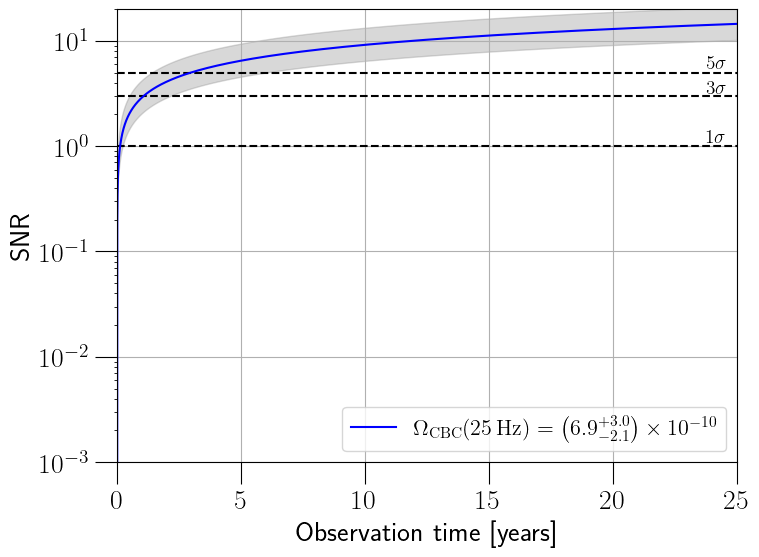

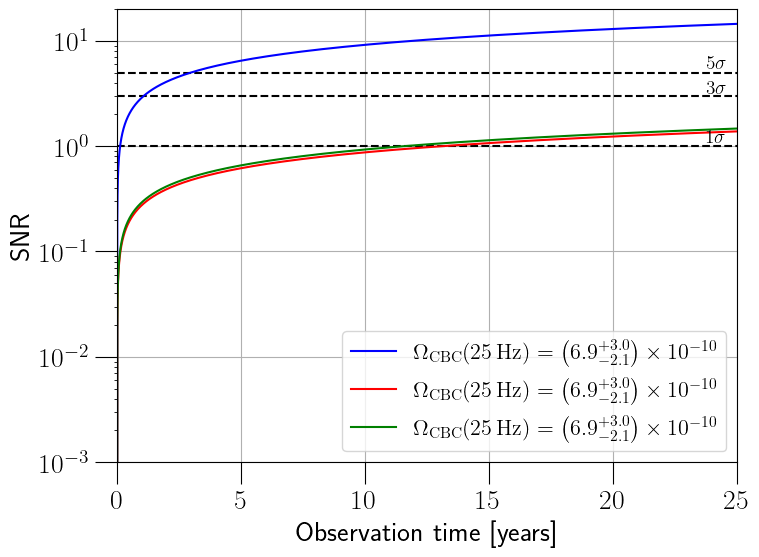

HLV
For a power law Om_beta(25.0)=6.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 1.4212429523232963 months of observation.
Reaching SNR = 3 after 1.0627319076703357 years of observation.
Reaching SNR = 5 after 2.9629288069063078 years of observation.

Optimistic scenario: Om_beta(25.0)=9.9e-10 with spectral index beta = 0.6666666666666666
Reaching SNR = 1 after 0.69336206456212 months of observation.
Reaching SNR = 3 after 0.518460259291916 years of observation.
Reaching SNR = 5 after 1.4454829354466434 years of observation.


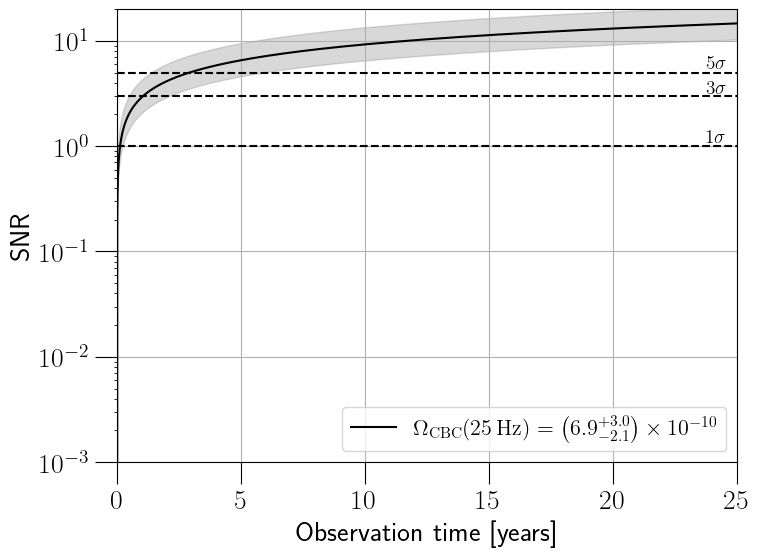

In [30]:
rescaled_obs_time = obs_time/86400/365.25

print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HL>1])[0]*365.25/30.4375} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HL>3])[0]} years of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HL>5])[0]} years of observation.\n")
except IndexError:
    pass
    
print(f"Optimistic scenario: Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HL*Om_beta_up_factor>1])[0]*365.25/30.4375} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HL*Om_beta_up_factor>3])[0]} years of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HL*Om_beta_up_factor>5])[0]} years of observation.")
except IndexError:
    pass

plt.plot(rescaled_obs_time, snr_t_HL, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.fill_between(rescaled_obs_time, snr_t_HL*Om_beta_up_factor, snr_t_HL*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [years]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()
plt.close()

plt.plot(rescaled_obs_time, snr_t_HL, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
#plt.fill_between(rescaled_obs_time, snr_t*Om_beta_up_factor, snr_t_HL*Om_beta_down_factor, color = "gray", alpha = 0.3)
plt.plot(rescaled_obs_time, snr_t_HV, color = "red", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.plot(rescaled_obs_time, snr_t_LV, color = "green", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")


plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [years]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()
plt.close()


print("HLV")
print(f"For a power law Om_beta({fref})={Om_beta} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HLV>1])[0]*365.25/30.4375} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HLV>3])[0]} years of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HLV>5])[0]} years of observation.\n")
except IndexError:
    pass

print(f"Optimistic scenario: Om_beta({fref})={Om_beta*Om_beta_up_factor} with spectral index beta = {beta}")
try:
    print(f"Reaching SNR = 1 after {(rescaled_obs_time[snr_t_HLV*Om_beta_up_factor>1])[0]*365.25/30.4375} months of observation.")
    print(f"Reaching SNR = 3 after {(rescaled_obs_time[snr_t_HLV*Om_beta_up_factor>3])[0]} years of observation.")
    print(f"Reaching SNR = 5 after {(rescaled_obs_time[snr_t_HLV*Om_beta_up_factor>5])[0]} years of observation.")
except IndexError:
    pass

plt.plot(rescaled_obs_time, snr_t_HLV, color = "black", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.fill_between(rescaled_obs_time, snr_t_HLV*Om_beta_up_factor, snr_t_HLV*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [years]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()
plt.close()

## Trying plot combining runs
Something like what was done in https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.091101

### Loading ASDs for different runs

In [31]:
observing_run_asds = {"o1": path_to_det + "o1.txt", "o2": path_to_det + "o2.txt",\
                      "o3_H": path_to_det + "o3_h1.txt", "o3_L": path_to_det + "o3_l1.txt",\
                      "o3_V": path_to_det + "o3_v1.txt"}

In [32]:
f_o1, asd_o1 = np.transpose(np.loadtxt(observing_run_asds["o1"]))
f_o2, asd_o2 = np.transpose(np.loadtxt(observing_run_asds["o2"]))
f_o3_H, asd_o3_H = np.transpose(np.loadtxt(observing_run_asds["o3_H"]))
f_o3_L, asd_o3_L = np.transpose(np.loadtxt(observing_run_asds["o3_L"]))
f_o3_V, asd_o3_V = np.transpose(np.loadtxt(observing_run_asds["o3_V"]))
f_o4_H_design, asd_o4_H_design = np.transpose(np.loadtxt(detectors_asds["aligo"]))
f_o5_H_plus, asd_o5_H_plus = np.transpose(np.loadtxt(detectors_asds["aligo+"]))

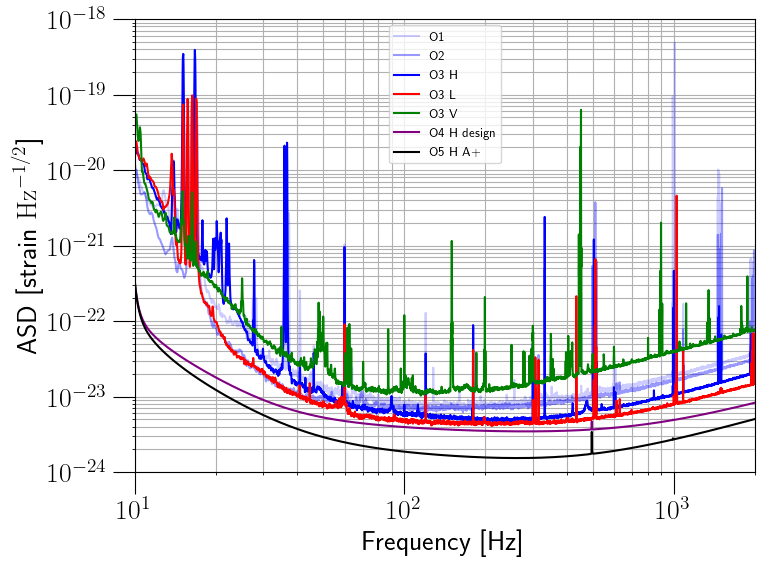

In [33]:
plt.loglog(f_o1, asd_o1, color = "blue", alpha = 0.2, label = "O1")
plt.loglog(f_o2, asd_o2, color = "blue", alpha = 0.4, label = "O2")
plt.loglog(f_o3_H, asd_o3_H, color = "blue", label = "O3 H")
plt.loglog(f_o3_L, asd_o3_L, color = "red", label = "O3 L")
plt.loglog(f_o3_V, asd_o3_V, color = "green", label = "O3 V")
plt.loglog(f_o4_H_design, asd_o4_H_design, color = "purple", label = "O4 H design")
plt.loglog(f_o5_H_plus, asd_o5_H_plus, color = "black", label = "O5 H A+")

plt.xlabel("Frequency [Hz]")
plt.ylabel(r"ASD [strain $\mathrm{Hz}^{-1/2}$]")

plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-18)

plt.grid(which = "both")
plt.legend()
plt.show()
plt.close()

In [34]:
ORFs_data = np.load("ORF_full_healpy_nside_128.npz")#("ORF_small_healpy_nside_32.npz")
f_ORF = ORFs_data["freqs"]
ORF_HL = ORFs_data["ORF_HL"]/5# to recover unnormalised orf

f_pi = np.linspace(10,2000, 1990+1)#np.linspace(1,1726, 1725*4+1)

ORF_HV = ORFs_data["ORF_HV"]/5# to recover unnormalised orf
ORF_LV = ORFs_data["ORF_LV"]/5# to recover unnormalised orf

/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with diff

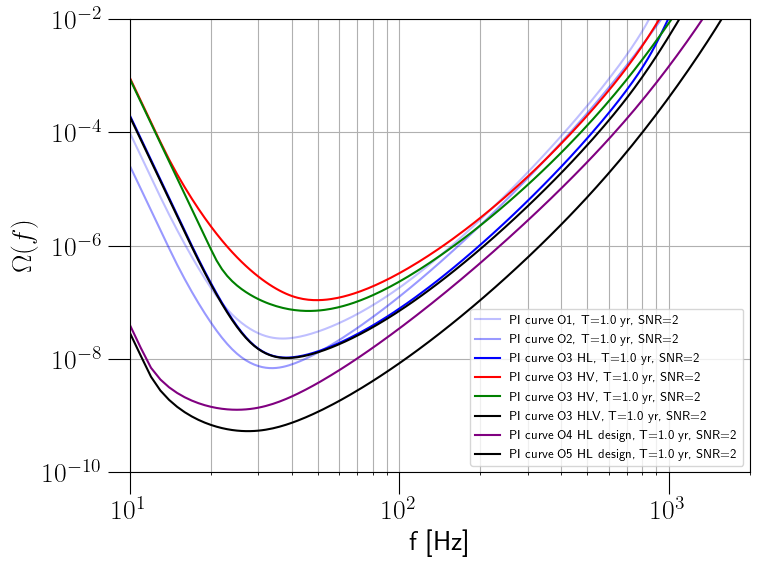

/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/delillo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with diff

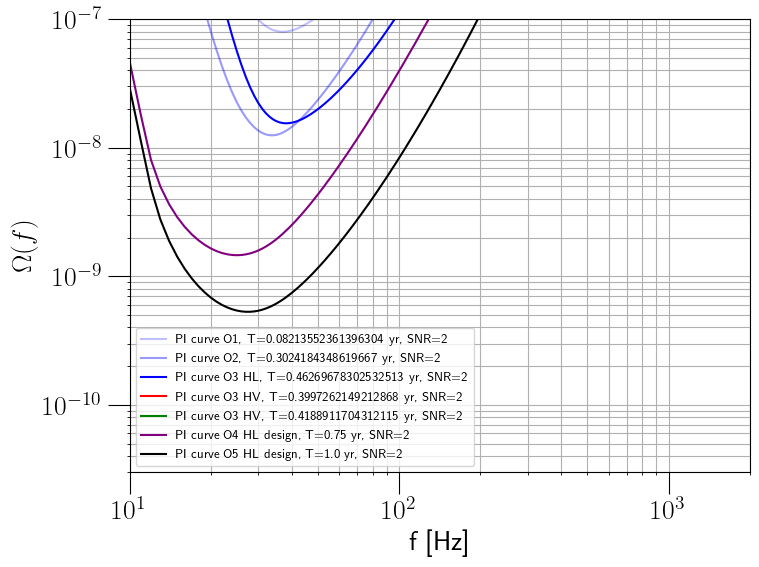

In [48]:
year = 365.25*86400
obs_time = year
snr = 2
fref = 25.

#actual abserving time taking into account the duty cycle
obs_time_o1 = 30*86400
obs_time_o2 = 99*96400
obs_time_o3_HL = 169*86400
obs_time_o3_HV = 146*86400
obs_time_o3_LV = 153*86400
obs_time_o4_HL = 0.75*year
obs_time_o5_HL = year


asd_o1_for_Om_eff = interp1d(f_o1, asd_o1, fill_value="extrapolate")(f_ORF)

S_o1_eff = np.power(ORF_HL**2/(asd_o1_for_Om_eff**4), -0.5)
OM_eff_o1 = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_o1_eff

OM_eff_o1_pi = interp1d(f_ORF, OM_eff_o1, fill_value="extrapolate")(f_pi)
PI_curve_o1, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o1_pi, obs_time = obs_time, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o1, label = r"PI curve O1, T={} yr, SNR={}".format(obs_time/year, str(snr)),\
           color = "blue", alpha = 0.25)


asd_o2_for_Om_eff = interp1d(f_o2, asd_o2, fill_value="extrapolate")(f_ORF)

S_o2_eff = np.power(ORF_HL**2/(asd_o2_for_Om_eff**4), -0.5)
OM_eff_o2 = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_o2_eff

OM_eff_o2_pi = interp1d(f_ORF, OM_eff_o2, fill_value="extrapolate")(f_pi)
PI_curve_o2, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o2_pi, obs_time = obs_time, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o2, label = r"PI curve O2, T={} yr, SNR={}".format(obs_time/year, str(snr)),\
           color = "blue", alpha = 0.4)



asd_o3_H_for_Om_eff = interp1d(f_o3_H, asd_o3_H, fill_value="extrapolate")(f_ORF)
asd_o3_L_for_Om_eff = interp1d(f_o3_L, asd_o3_L, fill_value="extrapolate")(f_ORF)
asd_o3_V_for_Om_eff = interp1d(f_o3_V, asd_o3_V, fill_value="extrapolate")(f_ORF)
asd_o4_H_design_for_Om_eff = interp1d(f_o4_H_design, asd_o4_H_design, fill_value="extrapolate")(f_ORF)
asd_o5_H_plus_for_Om_eff = interp1d(f_o5_H_plus, asd_o5_H_plus, fill_value="extrapolate")(f_ORF)


S_o3_HL_eff = np.power(ORF_HL**2/(np.square(asd_o3_H_for_Om_eff)*np.square(asd_o3_L_for_Om_eff)), -0.5)
OM_eff_o3_HL = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_o3_HL_eff

OM_eff_o3_HL_pi = interp1d(f_ORF, OM_eff_o3_HL, fill_value="extrapolate")(f_pi)
PI_curve_o3_HL, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o3_HL_pi, obs_time = obs_time, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o3_HL, label = r"PI curve O3 HL, T={} yr, SNR={}".format(obs_time/year, str(snr)),\
           color = "blue")

S_o3_HV_eff = np.power(ORF_HV**2/(np.square(asd_o3_H_for_Om_eff)*np.square(asd_o3_V_for_Om_eff)), -0.5)
OM_eff_o3_HV = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_o3_HV_eff

OM_eff_o3_HV_pi = interp1d(f_ORF, OM_eff_o3_HV, fill_value="extrapolate")(f_pi)
PI_curve_o3_HV, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o3_HV_pi, obs_time = obs_time, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o3_HV, label = r"PI curve O3 HV, T={} yr, SNR={}".format(obs_time/year, str(snr)),\
           color = "red")

S_o3_LV_eff = np.power(ORF_LV**2/(np.square(asd_o3_L_for_Om_eff)*np.square(asd_o3_V_for_Om_eff)), -0.5)
OM_eff_o3_LV = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_o3_LV_eff

OM_eff_o3_LV_pi = interp1d(f_ORF, OM_eff_o3_LV, fill_value="extrapolate")(f_pi)
PI_curve_o3_LV, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o3_LV_pi, obs_time = obs_time, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o3_LV, label = r"PI curve O3 HV, T={} yr, SNR={}".format(obs_time/year, str(snr)),\
           color = "green")

S_eff_o3_array = [ORF_HL**2/(np.square(asd_o3_H_for_Om_eff)*np.square(asd_o3_L_for_Om_eff)),\
               ORF_HV**2/(np.square(asd_o3_H_for_Om_eff)*np.square(asd_o3_V_for_Om_eff)),\
               ORF_LV**2/(np.square(asd_o3_L_for_Om_eff)*np.square(asd_o3_V_for_Om_eff))]

S_o3_HLV_eff = np.power(np.sum(S_eff_o3_array, axis = 0), -0.5)
OM_eff_o3_HLV = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_o3_HLV_eff

OM_eff_o3_HLV_pi = interp1d(f_ORF, OM_eff_o3_HLV, fill_value="extrapolate")(f_pi)

PI_curve_o3_HLV, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o3_HLV_pi, obs_time = obs_time, snr = snr, fref = fref))

plt.loglog(f_pi, PI_curve_o3_HLV, label = r"PI curve O3 HLV, T={} yr, SNR={}".format(obs_time/year, str(snr)),\
           color = "black")


S_o4_HL_design_eff = np.power(ORF_HL**2/(asd_o4_H_design_for_Om_eff**4), -0.5)
OM_eff_o4_HL_design = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_o4_HL_design_eff
OM_eff_o4_HL_design_pi = interp1d(f_ORF, OM_eff_o4_HL_design, fill_value="extrapolate")(f_pi)

PI_curve_o4_HL_design, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o4_HL_design_pi, obs_time = obs_time, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o4_HL_design, label = r"PI curve O4 HL design, T={} yr, SNR={}".format(obs_time/year, str(snr)),\
           color = "purple")

S_o5_HL_plus_eff = np.power(ORF_HL**2/(asd_o5_H_plus_for_Om_eff**4), -0.5)
OM_eff_o5_HL_plus = 2*np.pi**2/(3*H0**2)*f_ORF**3*S_o5_HL_plus_eff
OM_eff_o5_HL_plus_pi = interp1d(f_ORF, OM_eff_o5_HL_plus, fill_value="extrapolate")(f_pi)

PI_curve_o5_HL_plus, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o5_HL_plus_pi, obs_time = obs_time, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o5_HL_plus, label = r"PI curve O5 HL design, T={} yr, SNR={}".format(obs_time/year, str(snr)),\
           color = "black")

plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
plt.ylim(1e-10,1e-2)#plt.ylim(3e-11,1e-7)
plt.grid(which = "both")
plt.legend()
plt.show()
plt.close()

PI_curve_o1, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o1_pi, obs_time = obs_time_o1, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o1, label = r"PI curve O1, T={} yr, SNR={}".format(obs_time_o1/year, str(snr)),\
           color = "blue", alpha = 0.25)

PI_curve_o2, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o2_pi, obs_time = obs_time_o2, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o2, label = r"PI curve O2, T={} yr, SNR={}".format(obs_time_o2/year, str(snr)),\
           color = "blue", alpha = 0.4)

PI_curve_o3_HL, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o3_HL_pi, obs_time = obs_time_o3_HL, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o3_HL, label = r"PI curve O3 HL, T={} yr, SNR={}".format(obs_time_o3_HL/year, str(snr)),\
           color = "blue")

PI_curve_o3_HV, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o3_HV_pi, obs_time = obs_time_o3_HV, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o3_HV, label = r"PI curve O3 HV, T={} yr, SNR={}".format(obs_time_o3_HV/year, str(snr)),\
           color = "red")

PI_curve_o3_LV, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o3_LV_pi, obs_time = obs_time_o3_LV, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o3_LV, label = r"PI curve O3 HV, T={} yr, SNR={}".format(obs_time_o3_LV/year, str(snr)),\
           color = "green")

PI_curve_o4_HL_design, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o4_HL_design_pi, obs_time = obs_time_o4_HL, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o4_HL_design, label = r"PI curve O4 HL design, T={} yr, SNR={}".format(obs_time_o4_HL/year, str(snr)),\
           color = "purple")

PI_curve_o5_HL_plus, _, _ = np.transpose(PI_mine(f_pi, OM_eff_o5_HL_plus_pi, obs_time = obs_time, snr = snr, fref = fref))
plt.loglog(f_pi, PI_curve_o5_HL_plus, label = r"PI curve O5 HL design, T={} yr, SNR={}".format(obs_time_o5_HL/year, str(snr)),\
           color = "black")

plt.xlabel("f [Hz]")
plt.ylabel(r"$\Omega(f)$")
plt.xlim(10,2000)
plt.ylim(3e-11,1e-7)
plt.grid(which = "both")
plt.legend()
plt.show()
plt.close()

In [49]:
#After GW170817 paper: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.091101
Om_beta = 1.8e-9
Om_beta_up_factor = (Om_beta+2.7e-9)/Om_beta
Om_beta_down_factor = (Om_beta-1.3e-9)/Om_beta
beta = 2./3
fref = 25.

obs_times_o1 = np.append(0, np.logspace(0, np.log10(obs_time_o1), 1000))
obs_times_o2 = np.append(0, np.logspace(0, np.log10(obs_time_o2), 1000))
obs_times_o3_HL = np.append(0, np.logspace(0, np.log10(obs_time_o3_HL), 1000))
obs_times_o4_HL_design = np.append(0, np.logspace(0, np.log10(0.75*year), 1000))
obs_times_o5_HL_design = np.append(0, np.logspace(0, np.log10(year), 1000))


#print(obs_time)
snr_t_o1 = PI_SNR(f_pi, OM_eff_o1_pi, obs_time = obs_times_o1, fref = fref, beta = beta, Om_beta = Om_beta)

snr_t_o2 = np.sqrt(snr_t_o1[-1]**2 + \
           np.square(PI_SNR(f_pi, OM_eff_o2_pi, obs_time = obs_times_o2, fref = fref, beta = beta, Om_beta = Om_beta)))

snr_t_o3_HL = np.sqrt(snr_t_o2[-1]**2 + \
              np.square(PI_SNR(f_pi, OM_eff_o3_HL_pi, obs_time = obs_times_o3_HL, fref = fref, beta = beta, Om_beta = Om_beta)))

snr_t_o4_HL_design = np.sqrt(snr_t_o3_HL[-1]**2 + \
              np.square(PI_SNR(f_pi, OM_eff_o4_HL_design_pi, obs_time = obs_times_o4_HL_design, fref = fref, beta = beta, Om_beta = Om_beta)))

snr_t_o5_HL_design = np.sqrt(snr_t_o4_HL_design[-1]**2 + \
              np.square(PI_SNR(f_pi, OM_eff_o4_HL_design_pi, obs_time = obs_times_o5_HL_design, fref = fref, beta = beta, Om_beta = Om_beta)))


snr_t_o4_HL_realistic = np.sqrt(snr_t_o3_HL[-1]**2 + \
              np.square(PI_SNR(f_pi, OM_eff_o3_HL_pi/1.4, obs_time = obs_times_o4_HL_design, fref = fref, beta = beta, Om_beta = Om_beta)))

snr_t_o5_HL_realistic = np.sqrt(snr_t_o4_HL_realistic[-1]**2 + \
              np.square(PI_SNR(f_pi, OM_eff_o4_HL_design_pi, obs_time = obs_times_o5_HL_design, fref = fref, beta = beta, Om_beta = Om_beta)))

snr_t_o5_HL_plus = np.sqrt(snr_t_o4_HL_design[-1]**2 + \
              np.square(PI_SNR(f_pi, OM_eff_o5_HL_plus_pi, obs_time = obs_times_o5_HL_design, fref = fref, beta = beta, Om_beta = Om_beta)))


#snr_t_HV = PI_SNR(f_pi, OM_eff_HV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#snr_t_LV = PI_SNR(f_pi, OM_eff_LV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#snr_t_HLV = PI_SNR(f_pi, OM_eff_HLV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)

tot_obs_times = np.array([obs_times_o1, obs_times_o2 + obs_times_o1[-1],\
                         obs_times_o3_HL + obs_times_o2[-1] + obs_times_o1[-1],\
                         obs_times_o4_HL_design + obs_times_o3_HL[-1] + obs_times_o2[-1] + obs_times_o1[-1],\
                         obs_times_o5_HL_design + obs_times_o4_HL_design[-1] + obs_times_o3_HL[-1] +\
                         obs_times_o2[-1] + obs_times_o1[-1]]).flatten()
tot_snr_t = np.array([snr_t_o1, snr_t_o2, snr_t_o3_HL, snr_t_o4_HL_design, snr_t_o5_HL_design]).flatten()

tot_snr_t_realistic = np.array([snr_t_o1, snr_t_o2, snr_t_o3_HL, snr_t_o4_HL_realistic, snr_t_o5_HL_realistic]).flatten()

tot_snr_t_plus = np.array([snr_t_o1, snr_t_o2, snr_t_o3_HL, snr_t_o4_HL_design, snr_t_o5_HL_plus]).flatten()


#print(snr_t)

In [50]:
run_start_times = np.array([obs_times_o1[0], obs_times_o1[-1], obs_times_o1[-1] + obs_times_o2[-1],\
                  obs_times_o1[-1] + obs_times_o2[-1] + obs_times_o3_HL[-1],\
                  obs_times_o1[-1] + obs_times_o2[-1] + obs_times_o3_HL[-1] + obs_times_o4_HL_design[-1]])
run_start_SNR = np.array([snr_t_o1[0], snr_t_o2[0], snr_t_o3_HL[0], snr_t_o4_HL_design[0], snr_t_o5_HL_design[0]])
run_start_SNR_realistic = np.array([snr_t_o1[0], snr_t_o2[0], snr_t_o3_HL[0], snr_t_o4_HL_realistic[0], snr_t_o5_HL_realistic[0]])
run_start_SNR_plus = np.array([snr_t_o1[0], snr_t_o2[0], snr_t_o3_HL[0], snr_t_o4_HL_design[0], snr_t_o5_HL_plus[0]])


run_end_SNR = np.array([snr_t_o1[-1], snr_t_o2[-1], snr_t_o3_HL[-1], snr_t_o4_HL_design[-1], snr_t_o5_HL_design[-1]])
print(run_start_SNR, "\n", run_end_SNR)

[0.         0.06028773 0.36384933 0.48174013 2.62289833] 
 [0.06028773 0.36384933 0.48174013 2.62289833 3.96773972]


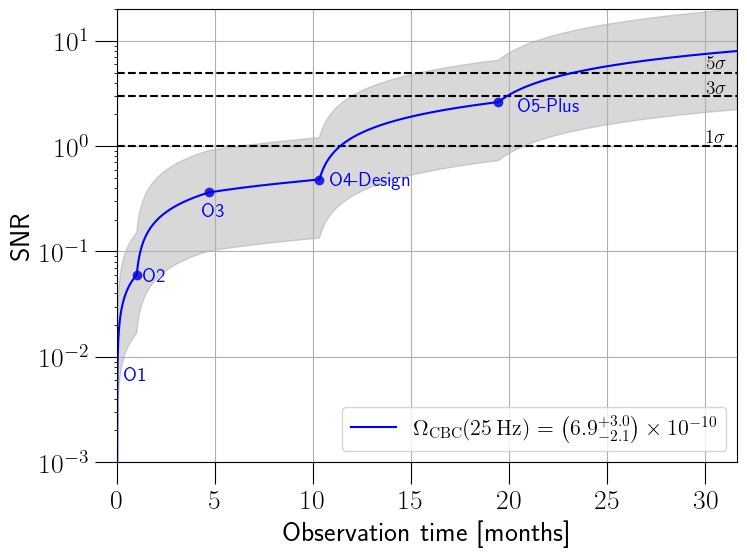

In [54]:
rescaled_obs_time = tot_obs_times/86400/30
rescaled_start_time = run_start_times/86400/30

plt.plot(rescaled_obs_time, tot_snr_t_plus, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.scatter(rescaled_start_time, run_start_SNR_plus, color = "blue")
plt.fill_between(rescaled_obs_time, tot_snr_t_plus*Om_beta_up_factor, tot_snr_t_plus*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
plt.annotate("O1", (rescaled_start_time[1]/3, run_start_SNR_plus[1]/10), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O2", (rescaled_start_time[1]*1.3, run_start_SNR_plus[1]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O3", (rescaled_start_time[2]*0.925, run_start_SNR_plus[2]*0.6), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O4-Design", (rescaled_start_time[3]*1.05, run_start_SNR_plus[3]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O5-Plus", (rescaled_start_time[4]*1.05, run_start_SNR_plus[4]*0.825), textcoords = 'data',\
             color = "blue", fontsize = 14)

#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()
plt.close()

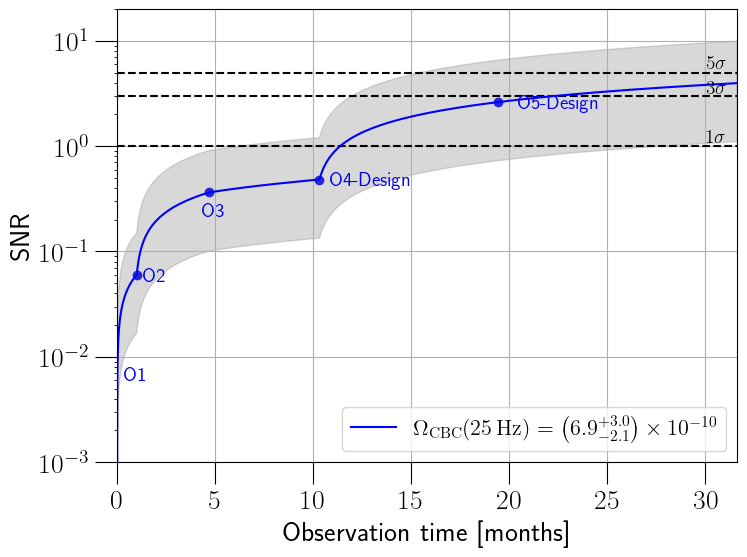

In [55]:
rescaled_obs_time = tot_obs_times/86400/30
rescaled_start_time = run_start_times/86400/30

plt.plot(rescaled_obs_time, tot_snr_t, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.scatter(rescaled_start_time, run_start_SNR, color = "blue")
plt.fill_between(rescaled_obs_time, tot_snr_t*Om_beta_up_factor, tot_snr_t*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
plt.annotate("O1", (rescaled_start_time[1]/3, run_start_SNR[1]/10), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O2", (rescaled_start_time[1]*1.3, run_start_SNR[1]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O3", (rescaled_start_time[2]*0.925, run_start_SNR[2]*0.6), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O4-Design", (rescaled_start_time[3]*1.05, run_start_SNR[3]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O5-Design", (rescaled_start_time[4]*1.05, run_start_SNR[4]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)

#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()
plt.close()

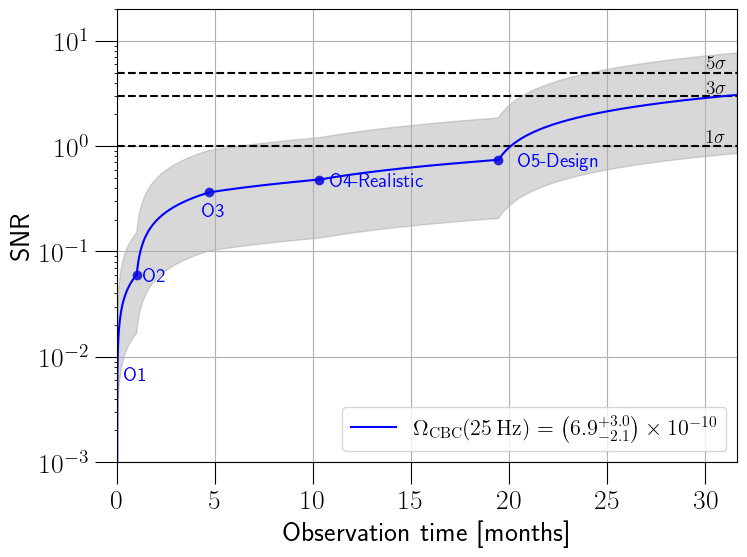

In [56]:
rescaled_obs_time = tot_obs_times/86400/30
rescaled_start_time = run_start_times/86400/30

plt.plot(rescaled_obs_time, tot_snr_t_realistic, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.scatter(rescaled_start_time, run_start_SNR_realistic, color = "blue")
plt.fill_between(rescaled_obs_time, tot_snr_t_realistic*Om_beta_up_factor, tot_snr_t_realistic*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
plt.annotate("O1", (rescaled_start_time[1]/3, run_start_SNR[1]/10), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O2", (rescaled_start_time[1]*1.3, run_start_SNR[1]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O3", (rescaled_start_time[2]*0.925, run_start_SNR[2]*0.6), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O4-Realistic", (rescaled_start_time[3]*1.05, run_start_SNR[3]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O5-Design", (rescaled_start_time[4]*1.05, run_start_SNR_realistic[4]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)

#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()
plt.close()

In [57]:
#GWTC-3
Om_beta = 6.9e-10
Om_beta_up_factor = (Om_beta+3.0e-10)/Om_beta
Om_beta_down_factor = (Om_beta-2.1e-10)/Om_beta
beta = 2./3
fref = 25.

obs_times_o1 = np.append(0, np.logspace(0, np.log10(obs_time_o1), 1000))
obs_times_o2 = np.append(0, np.logspace(0, np.log10(obs_time_o2), 1000))
obs_times_o3_HL = np.append(0, np.logspace(0, np.log10(obs_time_o3_HL), 1000))
obs_times_o4_HL_design = np.append(0, np.logspace(0, np.log10(0.75*year), 1000))

#print(obs_time)
snr_t_o1 = PI_SNR(f_pi, OM_eff_o1_pi, obs_time = obs_times_o1, fref = fref, beta = beta, Om_beta = Om_beta)

snr_t_o2 = np.sqrt(snr_t_o1[-1]**2 + \
           np.square(PI_SNR(f_pi, OM_eff_o2_pi, obs_time = obs_times_o2, fref = fref, beta = beta, Om_beta = Om_beta)))

snr_t_o3_HL = np.sqrt(snr_t_o2[-1]**2 + \
              np.square(PI_SNR(f_pi, OM_eff_o3_HL_pi, obs_time = obs_times_o3_HL, fref = fref, beta = beta, Om_beta = Om_beta)))

snr_t_o4_HL_design = np.sqrt(snr_t_o3_HL[-1]**2 + \
              np.square(PI_SNR(f_pi, OM_eff_o4_HL_design_pi, obs_time = obs_times_o4_HL_design, fref = fref, beta = beta, Om_beta = Om_beta)))

snr_t_o5_HL_design = np.sqrt(snr_t_o4_HL_design[-1]**2 + \
              np.square(PI_SNR(f_pi, OM_eff_o4_HL_design_pi, obs_time = obs_times_o5_HL_design, fref = fref, beta = beta, Om_beta = Om_beta)))


snr_t_o4_HL_realistic = np.sqrt(snr_t_o3_HL[-1]**2 + \
              np.square(PI_SNR(f_pi, OM_eff_o3_HL_pi/1.4, obs_time = obs_times_o4_HL_design, fref = fref, beta = beta, Om_beta = Om_beta)))

snr_t_o5_HL_realistic = np.sqrt(snr_t_o4_HL_realistic[-1]**2 + \
              np.square(PI_SNR(f_pi, OM_eff_o4_HL_design_pi, obs_time = obs_times_o5_HL_design, fref = fref, beta = beta, Om_beta = Om_beta)))

snr_t_o5_HL_plus = np.sqrt(snr_t_o4_HL_design[-1]**2 + \
              np.square(PI_SNR(f_pi, OM_eff_o5_HL_plus_pi, obs_time = obs_times_o5_HL_design, fref = fref, beta = beta, Om_beta = Om_beta)))


#snr_t_HV = PI_SNR(f_pi, OM_eff_HV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#snr_t_LV = PI_SNR(f_pi, OM_eff_LV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)
#snr_t_HLV = PI_SNR(f_pi, OM_eff_HLV_pi, obs_time = obs_time, fref = fref, beta = beta, Om_beta = Om_beta)

tot_obs_times = np.array([obs_times_o1, obs_times_o2 + obs_times_o1[-1],\
                         obs_times_o3_HL + obs_times_o2[-1] + obs_times_o1[-1],\
                         obs_times_o4_HL_design + obs_times_o3_HL[-1] + obs_times_o2[-1] + obs_times_o1[-1],\
                         obs_times_o5_HL_design + obs_times_o4_HL_design[-1] + obs_times_o3_HL[-1] +\
                         obs_times_o2[-1] + obs_times_o1[-1]]).flatten()
tot_snr_t = np.array([snr_t_o1, snr_t_o2, snr_t_o3_HL, snr_t_o4_HL_design, snr_t_o5_HL_design]).flatten()

tot_snr_t_realistic = np.array([snr_t_o1, snr_t_o2, snr_t_o3_HL, snr_t_o4_HL_realistic, snr_t_o5_HL_realistic]).flatten()

tot_snr_t_plus = np.array([snr_t_o1, snr_t_o2, snr_t_o3_HL, snr_t_o4_HL_design, snr_t_o5_HL_plus]).flatten()

#print(snr_t)

In [58]:
run_start_times = np.array([obs_times_o1[0], obs_times_o1[-1], obs_times_o1[-1] + obs_times_o2[-1],\
                  obs_times_o1[-1] + obs_times_o2[-1] + obs_times_o3_HL[-1],\
                  obs_times_o1[-1] + obs_times_o2[-1] + obs_times_o3_HL[-1] + obs_times_o4_HL_design[-1]])
run_start_SNR = np.array([snr_t_o1[0], snr_t_o2[0], snr_t_o3_HL[0], snr_t_o4_HL_design[0], snr_t_o5_HL_design[0]])
run_start_SNR_realistic = np.array([snr_t_o1[0], snr_t_o2[0], snr_t_o3_HL[0], snr_t_o4_HL_realistic[0], snr_t_o5_HL_realistic[0]])
run_start_SNR_plus = np.array([snr_t_o1[0], snr_t_o2[0], snr_t_o3_HL[0], snr_t_o4_HL_design[0], snr_t_o5_HL_plus[0]])


run_end_SNR = np.array([snr_t_o1[-1], snr_t_o2[-1], snr_t_o3_HL[-1], snr_t_o4_HL_design[-1], snr_t_o5_HL_design[-1]])
print(run_start_SNR, "\n", run_end_SNR)

[0.         0.0231103  0.13947558 0.18466705 1.00544436] 
 [0.0231103  0.13947558 0.18466705 1.00544436 1.52096689]


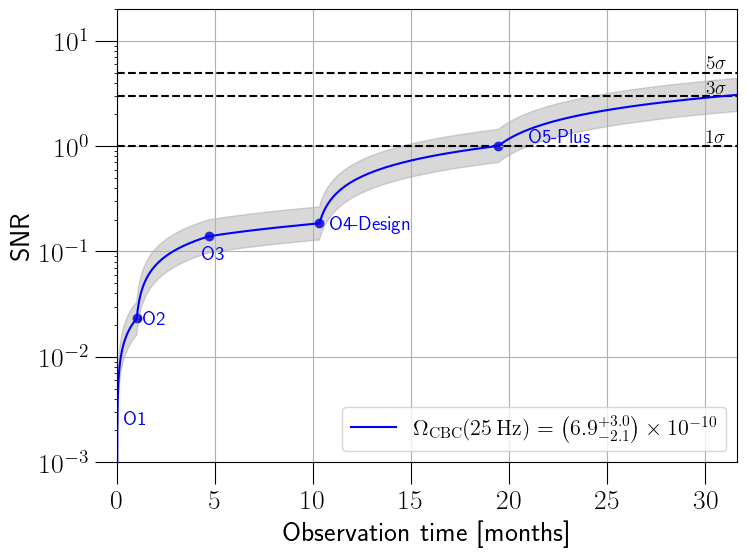

In [69]:
rescaled_obs_time = tot_obs_times/86400/30
rescaled_start_time = run_start_times/86400/30

plt.plot(rescaled_obs_time, tot_snr_t_plus, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.scatter(rescaled_start_time, run_start_SNR_plus, color = "blue")
plt.fill_between(rescaled_obs_time, tot_snr_t_plus*Om_beta_up_factor, tot_snr_t_plus*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
plt.annotate("O1", (rescaled_start_time[1]/3, run_start_SNR_plus[1]/10), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O2", (rescaled_start_time[1]*1.3, run_start_SNR_plus[1]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O3", (rescaled_start_time[2]*0.925, run_start_SNR_plus[2]*0.6), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O4-Design", (rescaled_start_time[3]*1.05, run_start_SNR_plus[3]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O5-Plus", (rescaled_start_time[4]*1.08, run_start_SNR_plus[4]*1.075), textcoords = 'data',\
             color = "blue", fontsize = 14)

#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()
plt.close()

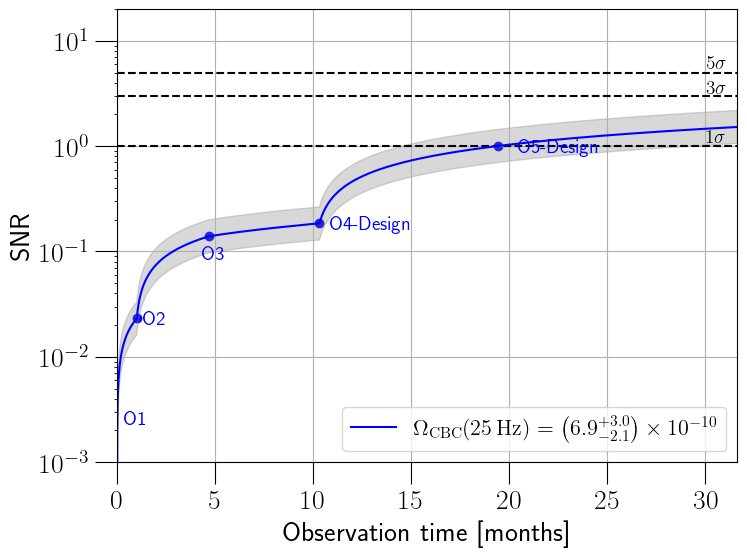

In [42]:
rescaled_obs_time = tot_obs_times/86400/30
rescaled_start_time = run_start_times/86400/30

plt.plot(rescaled_obs_time, tot_snr_t, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.scatter(rescaled_start_time, run_start_SNR, color = "blue")
plt.fill_between(rescaled_obs_time, tot_snr_t*Om_beta_up_factor, tot_snr_t*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
plt.annotate("O1", (rescaled_start_time[1]/3, run_start_SNR[1]/10), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O2", (rescaled_start_time[1]*1.3, run_start_SNR[1]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O3", (rescaled_start_time[2]*0.925, run_start_SNR[2]*0.6), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O4-Design", (rescaled_start_time[3]*1.05, run_start_SNR[3]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O5-Design", (rescaled_start_time[4]*1.05, run_start_SNR[4]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)

#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()
plt.close()

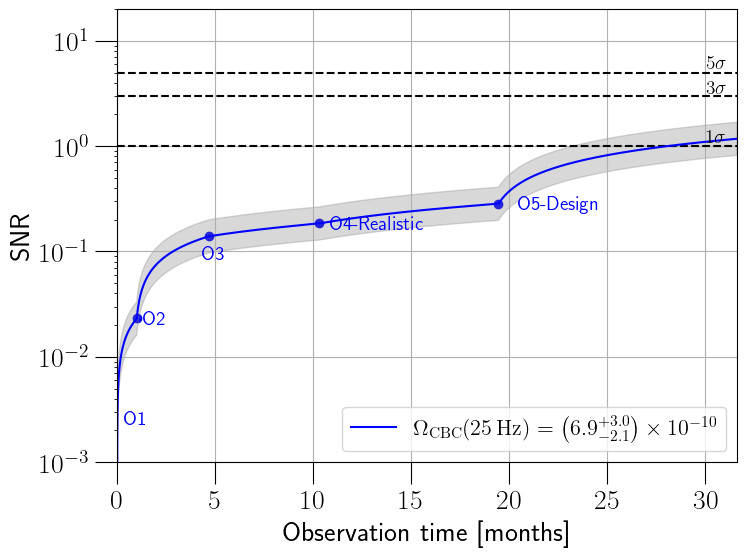

In [43]:
rescaled_obs_time = tot_obs_times/86400/30
rescaled_start_time = run_start_times/86400/30

plt.plot(rescaled_obs_time, tot_snr_t_realistic, color = "blue", label = r"$\Omega_{\mathrm{CBC}}(25\, {\rm Hz}) = \left(6.9^{+3.0}_{-2.1}\right)\times 10^{-10}$")
plt.scatter(rescaled_start_time, run_start_SNR_realistic, color = "blue")
plt.fill_between(rescaled_obs_time, tot_snr_t_realistic*Om_beta_up_factor, tot_snr_t_realistic*Om_beta_down_factor, color = "gray", alpha = 0.3)

plt.hlines(1, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(3, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.hlines(5, rescaled_obs_time[0], rescaled_obs_time[-1], linestyles="dashed", color = "black")
plt.annotate(r"$1\sigma$", (rescaled_obs_time[-1]*0.95, 1+0.1), textcoords='data', fontsize=14)
plt.annotate(r"$3\sigma$", (rescaled_obs_time[-1]*0.95, 3+0.2), textcoords='data', fontsize=14)
plt.annotate(r"$5\sigma$", (rescaled_obs_time[-1]*0.95, 5+0.5), textcoords='data', fontsize=14)
plt.annotate("O1", (rescaled_start_time[1]/3, run_start_SNR[1]/10), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O2", (rescaled_start_time[1]*1.3, run_start_SNR[1]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O3", (rescaled_start_time[2]*0.925, run_start_SNR[2]*0.6), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O4-Realistic", (rescaled_start_time[3]*1.05, run_start_SNR[3]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)
plt.annotate("O5-Design", (rescaled_start_time[4]*1.05, run_start_SNR_realistic[4]*0.875), textcoords = 'data',\
             color = "blue", fontsize = 14)

#plt.xscale("log")
plt.yscale("log")

plt.xlim(rescaled_obs_time[0], rescaled_obs_time[-1])
plt.ylim(1e-3, 20)
plt.xlabel("Observation time [months]")
plt.ylabel("SNR")
plt.grid()
plt.legend(fontsize = 20*0.8, loc="lower right")
#plt.savefig("Predicting_Armageddon_plot_HL_GWTC-3.pdf", bbox_inches = "tight")
plt.show()
plt.close()